# Sprint 3 - Modelo de Previsão de Risco de Crédito

### Descrição dos dataframes usados neste trabalho:

application_train.csv:
* Este é o arquivo principal, dividido em dois arquivos para Treinamento (com TARGET) e Teste (sem TARGET).
* Dados estáticos para todas as aplicações. Uma linha representa um empréstimo em nossa amostra de dados.

bureau.csv:
* Todos os créditos anteriores do cliente fornecidos por outras instituições financeiras que foram relatados ao Birô de Crédito (para clientes que têm um empréstimo em nossa amostra).
* Para cada empréstimo em nossa amostra, há mesma quantidade de linhas em relação a quantos créditos o cliente teve no Birô de Crédito antes da data da aplicação.

bureau_balance.csv:
* Saldos mensais de créditos anteriores no Birô de Crédito.
* Esta tabela tem uma linha para cada mês de histórico de cada crédito anterior relatado ao Birô de Crédito - ou seja, a tabela tem (# empréstimos na amostra * # de créditos anteriores relativos * # de meses em que temos algum histórico observável para os créditos anteriores) linhas.

POS_CASH_balance.csv:
* Fotos de saldo mensais de empréstimos POS (ponto de vendas) anteriores e empréstimos em dinheiro que o requerente teve com a Home Credit.
* Esta tabela tem uma linha para cada mês de histórico de cada crédito anterior na Home Credit (crédito ao consumidor e empréstimos em dinheiro) relacionado aos empréstimos em nossa amostra - ou seja, a tabela tem (# empréstimos na amostra * # de créditos anteriores relativos * # de meses em que temos algum histórico observável para os créditos anteriores) linhas.

credit_card_balance.csv:
* Fotos de saldo mensais de cartões de crédito anteriores que o requerente tem com a Home Credit.
* Esta tabela tem uma linha para cada mês de histórico de cada crédito anterior na Home Credit (crédito ao consumidor e empréstimos em dinheiro) relacionado aos empréstimos em nossa amostra - ou seja, a tabela tem (# empréstimos na amostra * # de cartões de crédito anteriores relativos * # de meses em que temos algum histórico observável para os cartões de crédito anteriores) linhas.

previous_application.csv:
* Todas as aplicações anteriores para empréstimos Home Credit de clientes que têm empréstimos em nossa amostra de dados.
* Há uma linha para cada aplicação anterior relacionada aos empréstimos em nossa amostra de dados.

installments_payments.csv:
* Histórico de pagamentos para os créditos previamente liberados na Home Credit relacionados aos empréstimos em nossa amostra de dados.
* Há uma linha para cada pagamento realizado mais uma linha para cada pagamento perdido. Uma linha é equivalente a um pagamento de uma prestação OU uma prestação correspondente a um pagamento de um crédito anterior da Home Credit relacionado aos empréstimos em nossa amostra de dados.

HomeCredit_columns_description.csv
* Contém a descrição das colunas de cada dataframe.

In [2]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, count

np.random.seed(55)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

# Pegando o SparkContext existente ou criando um novo
sc = SparkContext.getOrCreate()

spark = SparkSession.builder \
    .appName('credit_score') \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.driver.host", "localhost") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.memory.offHeap.enabled", True) \
    .config("spark.memory.offHeap.size", "2g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.cores", "4") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .getOrCreate()

# ajustando o nível de log do SparkSession e SparkContext para informar apenas o que estiver a nivel de ERROR
# (necessário em razão das configurações do Apache Spark no meu computador)
sc.setLogLevel("ERROR")
spark.sparkContext.setLogLevel("ERROR")

In [3]:
installments_p = spark.read.csv('datasets/installments_payments.csv', inferSchema=True, header=True)
app_train = spark.read.csv('datasets/application_train.csv', inferSchema=True, header=True)


In [4]:
cc_balance = pd.read_csv('datasets/credit_card_balance.csv', encoding='ISO-8859-1')
prev_app = pd.read_csv('datasets/previous_application.csv', encoding='ISO-8859-1')
POS_CASH_b = pd.read_csv('datasets/POS_CASH_balance.csv', encoding='ISO-8859-1')
bureau_b = pd.read_csv('datasets/bureau_balance.csv', encoding='ISO-8859-1')
bur = pd.read_csv('datasets/bureau.csv', encoding='ISO-8859-1')

In [5]:
home_cred = pd.read_csv('datasets/HomeCredit_columns_description.csv', encoding='ISO-8859-1')

# 1. Unindo os Dataframes

A mera junção entre `app_train` e `installments_p` estava gerando um dataframe com mais de 11 milhões de linhas, cujo tratamento era uma verdadeira impossibilidade no meu computador. O motivo desse aumento se dava em razão da repetição dos valores de `SK_ID_CURR`. Essa repetição indica múltiplas parcelas ou reacertos em um mesmo empréstimo. 

Assim, a forma que encontrei para mitigar esse aumento foi escolher apenas os maiores valores em `DAYS_ENTRY_PAYMENT`. Essa variável representa a diferença de dias entre a data da aplicação do crédito e o pagamento. Se a diferença é negativa, significa que o pagamento foi feito antes da data da aplicação. O valor maior indica que o pagamento foi feito com menos antecedência, é zero ou foi feito com atraso. Achei mais proveitoso dessa forma, pois quem paga atrasado tem uma maior tendência a permanecer inadimplente. Além disso, a nossa amostra tem um desequilíbrio bastante pronunciado na variável `TARGET`, tendo muito mais valores como 0 (pagadores) do que 1 (não pagadores).

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Criando uma janela e ordenando de forma decrescente para pegar o maior valor
window_spec = Window.partitionBy("SK_ID_CURR").orderBy(F.desc("DAYS_ENTRY_PAYMENT"))

# Adicionando índice de ocorrência para cada SK_ID_CURR
installments_p_with_index = installments_p.withColumn("row_num", row_number().over(window_spec))

# Selecionando apenas o registro mais próximo da data de aplicação
installments_p_latest = installments_p_with_index.filter(F.col("row_num") == 1).drop("row_num")

# Juntando com o app_train
app_train_with_features = app_train.join(installments_p_latest, on="SK_ID_CURR", how="left")


In [7]:
app_train_merged = app_train_with_features.pandas_api()

In [8]:
app_train_merged.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1810518,2.00,7,-536.00,-544.00,560835.36,560835.36
1,100007,0,Cash loans,M,N,Y,0,121500.00,513000.00,21865.50,513000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.03,-19932,-3038,-4311.00,-3458,NaN,1,1,0,1,0,0,Core staff,1.00,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,NaN,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.00,0.00,0.00,0.00,-1106.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1692033,1.00,12,-14.00,-14.00,16037.64,16037.64
2,100020,0,Cash loans,M,N,N,0,108000.00,509602.50,26149.50,387000.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.02,-12931,-1317,-6392.00,-3866,NaN,1,1,0,1,0,0,Drivers,2.00,2,2,THURSDAY,12,0,0,0,1,1,0,Government,NaN,0.24,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [9]:
num_linhas = app_train_merged.count()
print(f"Número de linhas: {num_linhas}")

num_colunas = len(app_train_merged.columns)
print(f"Número de colunas: {num_colunas}")

Número de linhas: SK_ID_CURR                      307511
TARGET                          307511
NAME_CONTRACT_TYPE              307511
CODE_GENDER                     307511
FLAG_OWN_CAR                    307511
FLAG_OWN_REALTY                 307511
CNT_CHILDREN                    307511
AMT_INCOME_TOTAL                307511
AMT_CREDIT                      307511
AMT_ANNUITY                     307499
AMT_GOODS_PRICE                 307233
NAME_TYPE_SUITE                 306219
NAME_INCOME_TYPE                307511
NAME_EDUCATION_TYPE             307511
NAME_FAMILY_STATUS              307511
NAME_HOUSING_TYPE               307511
REGION_POPULATION_RELATIVE      307511
DAYS_BIRTH                      307511
DAYS_EMPLOYED                   307511
DAYS_REGISTRATION               307511
DAYS_ID_PUBLISH                 307511
OWN_CAR_AGE                     104582
FLAG_MOBIL                      307511
FLAG_EMP_PHONE                  307511
FLAG_WORK_PHONE                 307511
FLAG_CO

Podemos notar que há bastante dados faltantes. Vamos tratar isso mais para frente. Prossigamos agora com o `.join()` com outros dataframes.

In [10]:
app_train_pandas = app_train_with_features.toPandas()
merged_df2 = pd.merge(app_train_pandas, prev_app, on=['SK_ID_CURR', 'SK_ID_PREV'], how='inner', suffixes=('', '_y'))

Mesmo fazendo o merge usando dois parâmetros, houve colunas duplicadas em `merge_df2`. Vamos ter que analisar isso mais de perto. A coluna `NAME_CONTRACT_TYPE`, por exemplo, parece ter menos detalhes que a sua duplicada. A nova coluna acrescenta um valor novo: consumer loans. Pode haver bastante relevância nessa terceira diferenciação, em termos de risco de crédito, conforme podemos inferir das definições abaixo de cada categoria:

* Cash Loans: Empréstimo único, montante fixo, uso flexível, geralmente usado para **compras emergenciais**.
* Revolving Loans: Linha de crédito reutilizável, pagamentos variáveis, limite de crédito.
* Consumer Loans: Empréstimo fixo, uso específico para compras pessoais, prazos e montantes fixos em que, por vezes, **o próprio bem pode ser usado como garantia**. 

É possível que Cash Loans seja uma categoria de crédito mais arriscada, afinal, o empréstimo é tomado na emergência. E em Consumer Loans, o gasto, além de ser melhor planejado, pode ser respaldado pelo próprio bem dado em garantia.

In [11]:
app_train_pandas['NAME_CONTRACT_TYPE'].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

In [12]:
merged_df2['NAME_CONTRACT_TYPE_y'].unique()

array(['Cash loans', 'Consumer loans', 'Revolving loans'], dtype=object)

In [13]:
rows = merged_df2.shape[0]
count = merged_df2['NAME_CONTRACT_TYPE_y'].value_counts().get('Consumer loans', 0)
per = count / rows * 100

print(f"Total de linhas: {rows};") 
print(f"Total de linhas com Consumer Loans: {count};")
print(f"Porcentagem de Consumer Loans em relação ao todo: {per:.2f}%.")


Total de linhas: 284766;
Total de linhas com Consumer Loans: 154890;
Porcentagem de Consumer Loans em relação ao todo: 54.39%.


Podemos ver acima que há uma quantidade expressiva de Consumer Loans, e portanto, a sua coluna é a que deve ser mantida. 

In [14]:
# Removendo 'NAME_CONTRACT_TYPE'
merged_df2.drop(columns=['NAME_CONTRACT_TYPE'], inplace=True)
merged_df2.rename(columns={'NAME_CONTRACT_TYPE_y': 'NAME_CONTRACT_TYPE'}, inplace=True)


Agora vamos tratar as demais colunas duplicadas. Vejamos a descrição delas:  

**AMT_ANNUITY_y - Annuity of Previous Application**
<br>
Indica o valor da parcela mensal a ser paga no empréstimo da aplicação anterior.

**AMT_CREDIT_y - Credit Amount of the Loan**
<br>
Indica o valor final do crédito concedido no empréstimo anterior (que pode ser diferente do valor solicitado inicialmente).

**AMT_GOODS_PRICE_y - Price of the Goods for Consumer Loans**
<br>
Indica o preço dos bens adquiridos com o empréstimo para Consumer Loans.

Estas três últimas colunas podem, já de cara, ser descartadas, pois pouco influenciam no risco do crédito.

**WEEKDAY_APPR_PROCESS_START_y - Day of the Week When the Loan Application Started**
<br>
Indica o dia da semana em que o cliente iniciou o processo de solicitação do empréstimo.

**HOUR_APPR_PROCESS_START_y - Hour of the Day When the Loan Application Started**
<br>
A hora do dia em que o cliente iniciou o processo de solicitação do empréstimo.

**NAME_TYPE_SUITE_y - Who Was Accompanying the Client When Applying for the Loan**
<br>
A pessoa ou grupo que acompanhou o cliente durante o processo de solicitação do empréstimo. 


Vamos olhar alguns dados dessas colunas, para decidir quais colunas serão retiradas e quais serão mantidas.

In [16]:
desc_1 = merged_df2['AMT_ANNUITY_y'].describe()
desc_2 = merged_df2['AMT_ANNUITY'].describe()
desc_3 = merged_df2['AMT_CREDIT_y'].describe()
desc_4 = merged_df2['AMT_CREDIT'].describe()
desc_5 = merged_df2['AMT_GOODS_PRICE_y'].describe()
desc_6 = merged_df2['AMT_GOODS_PRICE'].describe()

comparison_df = pd.DataFrame({
    'AMT_ANNUITY_y': desc_1,
    'AMT_ANNUITY': desc_2,
    'AMT_CREDIT_y': desc_3,
    'AMT_CREDIT': desc_4,
    'AMT_GOODS_PRICE_y': desc_5,
    'AMT_GOODS_PRICE': desc_6,
})

comparison_df

,AMT_ANNUITY_y,AMT_ANNUITY,AMT_CREDIT_y,AMT_CREDIT,AMT_GOODS_PRICE_y,AMT_GOODS_PRICE
count,284762.00,284754.00,284766.00,284766.00,262976.00,284500.00
mean,16490.48,26908.56,254094.68,587766.69,238318.35,527676.18
std,14916.46,14058.97,315715.13,389693.99,299324.55,356371.13
min,0.00,1615.50,0.00,45000.00,0.00,40500.00
25%,6750.00,16524.00,67270.50,270000.00,64205.46,238500.00
50%,11625.91,24853.50,135000.00,508495.50,125433.00,450000.00
75%,21470.28,34465.50,291919.50,808650.00,270000.00,679500.00
max,300425.45,225000.00,4050000.00,3956274.00,4050000.00,3825000.00


Deletaremos as colunas "\_y", uma vez que, ao terem valores mínimos como zero e uma média bastante inferior, indicam possuir outliers ou menos informações.

In [17]:
# Removendo as colunas extras
merged_df2.drop(columns=['AMT_ANNUITY_y', 'AMT_CREDIT_y', 'AMT_GOODS_PRICE_y', 'WEEKDAY_APPR_PROCESS_START_y', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START_y', 'HOUR_APPR_PROCESS_START', 'NAME_TYPE_SUITE_y', 'NAME_TYPE_SUITE' ], inplace=True)

In [18]:
merged_df2.shape

(284766, 154)

In [19]:
POS_CASH_b.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1715348,367990,-33,36.00,35.00,Active,0,0
2,1784872,397406,-32,12.00,9.00,Active,0,0
3,1903291,269225,-35,48.00,42.00,Active,0,0
4,2341044,334279,-35,36.00,35.00,Active,0,0


In [20]:
merged_df3 = pd.merge(merged_df2, POS_CASH_b, on=['SK_ID_CURR', 'SK_ID_PREV'], how='inner')

In [21]:
merged_df3.shape

(2610001, 160)

Nas minhas primeiras análises, eu tinha equilibrado a distribuição de `TARGET` para 50% de cada valor. No entanto, após orientação dos monitores, decidi manter a proporção dos dados, em que os inadimplentes representam 8% da amostra.

In [30]:
print(merged_df3['TARGET'].value_counts())
print(merged_df3['TARGET'].value_counts(normalize=True))

TARGET
0    2407784
1     202217
Name: count, dtype: int64
TARGET
0   0.92
1   0.08
Name: proportion, dtype: float64


Nota-se nova repetição de colunas, agora em `NAME_CONTRACT_STATUS`. Mas parece que não há utilidade me manter nenhuma das duas. Em uma só há um valor, e na outra, há pouquíssimos que não constam como aprovado, o que pode muito bem ser uma falha de atualização do sistema, apenas. Vamos deletar ambas.

In [22]:
merged_df3['NAME_CONTRACT_STATUS_x'].unique()

array(['Approved'], dtype=object)

In [23]:
merged_df3['NAME_CONTRACT_STATUS_y'].unique()

array(['Active', 'Completed', 'Signed', 'Approved',
       'Returned to the store', 'Demand', 'Canceled', 'Amortized debt'],
      dtype=object)

In [25]:
merged_df3.drop(columns=['NAME_CONTRACT_STATUS_y', 'NAME_CONTRACT_STATUS_x'], inplace=True)

Para a penúltima união, resolvi unir primeiro bureau_balance e bureau. No entanto, a união desses dataframes estava resultando num dataframe de mais de 24 milhões de linhas. Assim, selecionei apenas as linhas em que o valor de `MONTHS_BALANCE` era igual a 0, cujo valor indica que os dados apresentados pertencem aos balanços mais atualizados. E em seguida fiz o merge com `bur`.

In [26]:
bureau_filtered = bureau_b[bureau_b['MONTHS_BALANCE'] == 0] 

In [27]:
merged_df4 = bur.merge(bureau_filtered, on="SK_ID_BUREAU", how="inner", suffixes=('_bur', '_bureau_b'))

In [28]:
merged_df4.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE,STATUS
0,380361,5715448,Active,currency 1,-820,0,31069.00,NaN,NaN,0,67500.00,0.00,67500.00,0.00,Credit card,-183,0.00,0,C
1,380361,5715449,Active,currency 1,-357,0,1119.00,NaN,NaN,0,45000.00,0.00,45000.00,0.00,Credit card,-130,2691.00,0,C
2,380361,5715452,Closed,currency 1,-993,0,31039.00,-831.00,NaN,0,315000.00,0.00,0.00,0.00,Credit card,-818,0.00,0,C
3,380361,5715453,Closed,currency 1,-1146,0,681.00,-780.00,NaN,0,2025000.00,0.00,0.00,0.00,Consumer credit,-769,0.00,0,C
4,380361,5715457,Active,currency 1,-222,0,874.00,NaN,NaN,0,202500.00,31594.50,0.00,0.00,Credit card,-18,0.00,0,0


In [29]:
merged_df4.shape

(588522, 19)

E agora, finalmente podemos realizar a última união entre os dataframes.

In [30]:
df = pd.merge(merged_df3, merged_df4, on='SK_ID_CURR', how='inner')

In [31]:
df.shape

(2962037, 176)

Tratando as últimas colunas repetidas:

In [33]:
desc_1 = df['AMT_ANNUITY_y'].describe()
desc_2 = df['AMT_ANNUITY_x'].describe()
desc_3 = df['MONTHS_BALANCE_y'].describe()
desc_4 = df['MONTHS_BALANCE_x'].describe()


comp_df = pd.DataFrame({
    'AMT_ANNUITY_y': desc_1,
    'AMT_ANNUITY_x': desc_2,
    'MONTHS_BALANCE_y': desc_3,
    'MONTHS_BALANCE_x': desc_4
})

comp_df

,AMT_ANNUITY_y,AMT_ANNUITY_x,MONTHS_BALANCE_y,MONTHS_BALANCE_x
count,1845856.00,2961894.00,2962037.00,2962037.00
mean,14257.05,30487.69,0.00,-19.62
std,256303.40,15281.60,0.00,18.34
min,0.00,2295.00,0.00,-96.00
25%,0.00,19156.50,0.00,-24.00
50%,0.00,27963.00,0.00,-14.00
75%,12222.00,39424.50,0.00,-7.00
max,56844981.00,220297.50,0.00,-1.00


`MONTHS_BALANCE` é a coluna que usamos acima para unir dataframes, e através da qual selecionamos apenas as linhas que continham zero, para pegar os balanços mais recentes. Assim, ambas as colunas nesse caso devem ir embora. Em `AMT_ANNUITY_y`, vamos eliminar a coluna "_y", que possui muitos outliers e faltantes.

In [34]:
df.drop(columns=['AMT_ANNUITY_y', 'MONTHS_BALANCE_y', 'MONTHS_BALANCE_x'], inplace=True)

Comecemos aplicando função para remover as colunas que estejam duplicadas nos dataframes, a fim de em seguida darmos um join em todas.

1. Dar merge em todos os dataframes: Comece combinando todos os seus DataFrames em um único dataset. Isso garante que você tenha todas as informações necessárias em um único lugar.

2. Separar teste e treino: Divida seus dados em conjuntos de treino e teste antes de fazer qualquer pré-processamento ou análise para evitar qualquer tipo de "data leakage" (vazamento de dados). Isso ajuda a garantir que seu modelo seja avaliado de forma justa.

3. Verificar a distribuição dos dados e tratar distribuições: Analise a distribuição das variáveis. Trate valores ausentes, outliers e aplique transformações se necessário para normalizar ou padronizar as distribuições.

4. Calcular WoE (Weight of Evidence) e VI (Variable Importance): Use essas técnicas para transformar variáveis categóricas em valores numéricos (WoE) e avaliar a importância inicial das variáveis (VI).

5. Verificar multicolinearidade: Identifique e trate variáveis que estão altamente correlacionadas para evitar redundância e problemas durante o treinamento do modelo.

6. Fazer feature engineering: Crie novas variáveis a partir das existentes se necessário, para melhorar a performance do modelo.

7. Fazer feature selecting: Use técnicas de seleção de características para escolher as mais relevantes para o modelo. Isso pode incluir métodos automáticos ou baseados em análise manual.

8. Fazer feature importance: Após a seleção de características, utilize métodos de importância de características (como random forests ou gradient boosting) para confirmar quais variáveis são mais importantes.

9. Fazer cross-validation: Realize cross-validation para avaliar a performance do seu modelo de forma mais robusta e garantir que ele não esteja overfitting nos dados de treino.

10. Treinar o modelo: Finalmente, treine seu modelo de machine learning com os dados de treino, usando as características selecionadas.

1. Dar merge em todos os dataframes
2. EDA
3. Separar teste e treino
4. Verificar a distribuição dos dados e tratar distribuições
5. Calcular WoE (Weight of Evidence) e VI (Variable Importance)
6. Verificar multicolinearidade
7. Calcular Chi-square
8. Fazer feature engineering
9. Fazer feature selecting
10. Fazer feature importance
11. Fazer cross-validation
12. Treinar o modelo


# 2. Conhecendo o dataset

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2962037 entries, 0 to 2962036
Columns: 173 entries, SK_ID_CURR to STATUS
dtypes: float64(93), int32(40), int64(10), object(30)
memory usage: 3.4+ GB


## 2.1. Valores Nulos

Podemos ver abaixo, que há muitas colunas em que mais da metade dos valores são nulos.

In [37]:
# Definindo uma função para averiguar colunas com muitos dados faltantes
def missing_data(data):
    total = data.isna().sum().sort_values(ascending=False)
    percent = (data.isna().sum() / len(data) * 100).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [38]:
missing_data(df)

,Total,Percent
RATE_INTEREST_PRIMARY,2944194,99.40
RATE_INTEREST_PRIVILEGED,2944194,99.40
AMT_CREDIT_MAX_OVERDUE,2043918,69.00
COMMONAREA_AVG,2026107,68.40
COMMONAREA_MODE,2026107,68.40
COMMONAREA_MEDI,2026107,68.40
NONLIVINGAPARTMENTS_AVG,2014855,68.02
NONLIVINGAPARTMENTS_MEDI,2014855,68.02
NONLIVINGAPARTMENTS_MODE,2014855,68.02
LIVINGAPARTMENTS_AVG,1984825,67.01


Não parece haver nenhuma coluna com mais de 20% de dados faltantes que seja realmente necessária para a nossa análise. Assim, vamos removê-las. A única coluna que chama mais a atenção é a `OCCUPATION_TYPE`. No entanto, grande parte são funcionários que ganham a mesma faixa salarial. Assim, a coluna não fará falta.

In [39]:
df['OCCUPATION_TYPE'].unique()

array(['Managers', None, 'Low-skill Laborers', 'Sales staff', 'Laborers',
       'Core staff', 'Drivers', 'High skill tech staff', 'Accountants',
       'Medicine staff', 'Security staff', 'Secretaries', 'Cooking staff',
       'Private service staff', 'Cleaning staff', 'Waiters/barmen staff',
       'IT staff', 'HR staff', 'Realty agents'], dtype=object)

In [40]:
# Definindo uma função para remover colunas com mais de 20% de NaN
def remove_columns_with_missing_data(data, threshold=20.0):
    percent_missing = data.isna().sum() / len(data) * 100
    columns_to_keep = percent_missing[percent_missing < threshold].index
    return data[columns_to_keep]

In [41]:
df_filtered = remove_columns_with_missing_data(df)
df_filtered.shape

(2962037, 116)

Como temos uma quantidade de enorme de dados, podemos tranquilamente eliminar as linhas que contenham nulos.

In [43]:
df2 = df_filtered.dropna()
df2.shape

(2309047, 116)

E vamos remover duplicadas também.

In [261]:
df_no_duplicates = df2.drop_duplicates(keep='first')

In [262]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_no_duplicates, test_size=0.3, random_state=42)

In [263]:
train_df.shape

(1581348, 116)

## 2.2. Colunas Com Baixa Variação de Valores

### 2.2.1. Numéricas

Começando pelas numéricas, conforme vemos abaixo, há muitas colunas com variância zero ou próximo disso. Essa colunas, portanto, devem ser eliminadas, uma vez que não acrescentam nada ao nosso modelo. 

Decidi estabelecer o limiar de variância em 0.02, valor que pensei ser suficiente para eliminar boa parte das colunas menos influentes.

In [265]:
# Eliminando colunas com baixa variância
# Separando dados numéricos de categóricos
colunas_numericas = train_df.select_dtypes(include=['number']).columns
colunas_categoricas = train_df.select_dtypes(include=['object', 'category']).columns

variancias = train_df[colunas_numericas].var()

variancias

SK_ID_CURR                     10554757664.60
TARGET                                   0.07
CNT_CHILDREN                             0.50
AMT_INCOME_TOTAL               11864731325.27
AMT_CREDIT                    156146664986.14
AMT_ANNUITY_x                    232561677.18
AMT_GOODS_PRICE               134220608185.56
REGION_POPULATION_RELATIVE               0.00
DAYS_BIRTH                        17399865.49
DAYS_EMPLOYED                  21347740256.03
DAYS_REGISTRATION                 12632376.38
DAYS_ID_PUBLISH                    2204305.18
FLAG_MOBIL                               0.00
FLAG_EMP_PHONE                           0.16
FLAG_WORK_PHONE                          0.16
FLAG_CONT_MOBILE                         0.00
FLAG_PHONE                               0.20
FLAG_EMAIL                               0.10
CNT_FAM_MEMBERS                          0.77
REGION_RATING_CLIENT                     0.25
REGION_RATING_CLIENT_W_CITY              0.25
REG_REGION_NOT_LIVE_REGION        

In [266]:
# Filtrando
colunas_com_boa_variancia = variancias[variancias > 0.02].index
colunas_finais = list(colunas_categoricas) + list(colunas_com_boa_variancia)

In [267]:
# Criando dataframes apenas com as colunas finais
train_df_filt = train_df[colunas_finais]
test_df_filt = test_df[colunas_finais]

In [268]:
train_df_filt.shape

(1581348, 90)

### 2.2.2. Categóricas

Quanto às variáveis categóricas, há duas colunas que só possuem um valor único. 

In [269]:
# Colunas categóricas com apenas um valor único
single_value_cols = [col for col in train_df_filt.columns if train_df_filt[col].nunique() == 1]

single_value_cols

['FLAG_LAST_APPL_PER_CONTRACT', 'CODE_REJECT_REASON']

In [270]:
# Removendo as colunas categóricas com um único valor
train_df_filt = train_df_filt.drop(columns=['FLAG_LAST_APPL_PER_CONTRACT', 'CODE_REJECT_REASON'])
test_df_filt = test_df_filt.drop(columns=['FLAG_LAST_APPL_PER_CONTRACT', 'CODE_REJECT_REASON'])


## 2.3. Correlação Entre as Colunas

### 2.3.1. Correlação entre Numéricas e `TARGET`

Achei melhor, de início separar as variáveis numéricas das categóricas. Há categóricas com mais de 20 valores únicos, o que resultaria em um dataframe muito grande, podendo gerar problemas de memória.

Assim, comecemos pelas variáveis numéricas.

In [271]:
# pegando uma amostra menor para não ter problemas de memória
sample_df = train_df_filt.sample(n=50000, random_state=42)

colunas_numericas = sample_df.select_dtypes(include=['number']).columns
colunas_categoricas = sample_df.select_dtypes(include=['object', 'category']).columns

df_dummies = pd.get_dummies(sample_df[colunas_categoricas], drop_first=True)

df_transformed = pd.concat([sample_df[colunas_numericas], df_dummies], axis=1)

df_transformed.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
2459020,368361,0,0,90000.00,785772.00,28354.50,585000.00,-21348,365243,-16063.00,...,False,False,False,False,False,False,False,False,False,True
2743997,299338,1,1,135000.00,113760.00,9117.00,90000.00,-12083,-3039,-2792.00,...,False,False,False,False,False,False,False,False,False,False
814324,182197,0,0,112500.00,477000.00,27382.50,477000.00,-19318,-324,-13234.00,...,False,False,False,False,False,False,False,False,True,False
1421062,411335,0,0,202500.00,364428.00,13869.00,238500.00,-18584,-8151,-8656.00,...,False,False,False,False,False,False,False,False,False,False
1009846,369947,0,0,270000.00,1096020.00,56092.50,900000.00,-19114,-244,-1806.00,...,False,False,False,False,False,False,False,False,False,True


In [272]:
# Verifique a matriz de correlação
corr_matrix = df_transformed.corr()['TARGET']

corr_matrix[colunas_numericas]

SK_ID_CURR                     0.00
TARGET                         1.00
CNT_CHILDREN                   0.02
AMT_INCOME_TOTAL              -0.01
AMT_CREDIT                    -0.03
AMT_ANNUITY_x                 -0.01
AMT_GOODS_PRICE               -0.03
DAYS_BIRTH                     0.06
DAYS_EMPLOYED                 -0.04
DAYS_REGISTRATION              0.04
DAYS_ID_PUBLISH                0.05
FLAG_EMP_PHONE                 0.04
FLAG_WORK_PHONE                0.02
FLAG_PHONE                    -0.03
FLAG_EMAIL                     0.01
CNT_FAM_MEMBERS                0.02
REGION_RATING_CLIENT           0.04
REGION_RATING_CLIENT_W_CITY    0.04
REG_REGION_NOT_WORK_REGION     0.01
LIVE_REGION_NOT_WORK_REGION    0.01
REG_CITY_NOT_LIVE_CITY         0.04
REG_CITY_NOT_WORK_CITY         0.05
LIVE_CITY_NOT_WORK_CITY        0.04
EXT_SOURCE_2                  -0.13
EXT_SOURCE_3                  -0.16
OBS_30_CNT_SOCIAL_CIRCLE       0.01
DEF_30_CNT_SOCIAL_CIRCLE       0.04
OBS_60_CNT_SOCIAL_CIRCLE    

Selecionei apenas as variáveis numéricas para analisar a correlação, pois mesmo convertendo as categóricas para numéricas, o método não pareceu apropriado. Podemos notar muitas variáveis numéricas com correlação perto de 0 em relação a `TARGET`. Vamos eliminar essas colunas de treino e teste.

In [273]:
colunas_zero_correlacao_numericas = [col for col in colunas_numericas if abs(corr_matrix[col]) < 1e-2]


In [274]:
colunas_zero_correlacao_numericas

['SK_ID_CURR',
 'AMT_ANNUITY_x',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_8',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'SK_ID_PREV',
 'DAYS_INSTALMENT',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL',
 'SK_DPD',
 'CREDIT_DAY_OVERDUE',
 'AMT_CREDIT_SUM_DEBT']

Retirando essas colunas de treino e teste:

In [275]:
train_df_filt = train_df_filt.drop(columns=colunas_zero_correlacao_numericas)
test_df_filt = test_df_filt.drop(columns=colunas_zero_correlacao_numericas)

### 2.3.2. Multicolinearidade

### Lasso

Para avaliar a multicolinearidade, escolhi usar Lasso. Pelo que entendi, Lasso é mais usando quando se busca reduzir a complexidade do dataframe. E como temos mais de 100 colunas, esse é o objetivo.

In [276]:
# Selecionando apenas numéricas
col_num = train_df_filt.select_dtypes(include=['number'])

In [277]:
# Pegando uma amostra de 500.000 linhas
sample_df = col_num.sample(n=500000, random_state=42)

In [278]:
X_sample = sample_df.drop(columns=['TARGET'])
y_sample = sample_df['TARGET']

In [279]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

lasso = Lasso(alpha=1.0)

lasso.fit(X_sample, y_sample)

# Identificando colunas com coeficientes zero
coefficients = lasso.coef_
zero_coeffs = [col for col, coef in zip(X_sample.columns, coefficients) if coef == 0]
print(f"Colunas com coeficientes zero: {zero_coeffs}")

Colunas com coeficientes zero: ['CNT_CHILDREN', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'CNT_PAYMENT', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD_DEF', 'DAYS_CREDIT_UPDATE']


Removendo essas colunas de teste e treino:

In [280]:
train_df_filt = train_df_filt.drop(columns=zero_coeffs)
test_df_filt = test_df_filt.drop(columns=zero_coeffs)

### VIF

Decidi prezar pela cautela e calcular VIF. E também foi detectada multicolinearidade.

In [281]:
# Selecionando apenas numéricas
cl_number = train_df_filt.select_dtypes(include=['number'])
sample_df = cl_number.sample(n=500000, random_state=42)
X_sample = sample_df.drop(columns=['TARGET'])
y_sample = sample_df['TARGET']

In [282]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calcular o VIF para a amostra inicial
X_sample_const = sm.add_constant(X_sample)
vif_before = calculate_vif(X_sample_const)

vif_before

,Variable,VIF
0,const,168.33
1,AMT_INCOME_TOTAL,1.23
2,AMT_CREDIT,45.76
3,AMT_GOODS_PRICE,45.72
4,DAYS_BIRTH,1.85
5,DAYS_EMPLOYED,1.76
6,DAYS_REGISTRATION,1.12
7,DAYS_ID_PUBLISH,1.09
8,DAYS_LAST_PHONE_CHANGE,1.06
9,AMT_APPLICATION,1.48


Há algumas colunas com VIF maior que 10. Assim vamos iterar sobre elas, eliminando uma por uma, a fim de obter um resultado que elimine apenas o necessário.

In [283]:
def remove_high_vif_features(X, vif_threshold=10):
    while True:
        vif_df = calculate_vif(X)

        max_vif = vif_df['VIF'].max()
        if max_vif > vif_threshold:
            # Encontra a variável com o maior VIF
            remove_variable = vif_df.sort_values('VIF', ascending=False).iloc[0]['Variable']
            print(f"Removendo variável '{remove_variable}' com VIF = {max_vif}")
            # Remova a variável com o maior VIF
            X = X.drop(columns=[remove_variable])
        else:
            break  # Saia do loop quando todos os VIFs estiverem abaixo do limiar
    
    return X

In [284]:
X_sample_const = sm.add_constant(X_sample)

In [285]:
X_sample_reduced = remove_high_vif_features(X_sample_const, vif_threshold=10)


Removendo variável 'const' com VIF = 168.33182432310426
Removendo variável 'AMT_CREDIT' com VIF = 153.96716754878005
Removendo variável 'DAYS_BIRTH' com VIF = 27.886616863363727
Removendo variável 'SK_ID_BUREAU' com VIF = 12.54953445192806


In [286]:
X_sample_reduced.columns

Index(['AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_APPLICATION', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_CREDIT',
       'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_OVERDUE'],
      dtype='object')

Removendo essas colunas de treino e teste.

In [287]:
colunas_remover = ['AMT_CREDIT', 'DAYS_BIRTH', 'SK_ID_BUREAU']

In [288]:
train_df_f = train_df_filt.drop(columns=colunas_remover)
test_df_f = test_df_filt.drop(columns=colunas_remover)

In [289]:
train_df_f.shape

(1581348, 36)

### 2.3.3. Variáveis Categóricas

Vamos comparar a frequência e a média de `TARGET` nos valores únicos de variáveis categóricas.

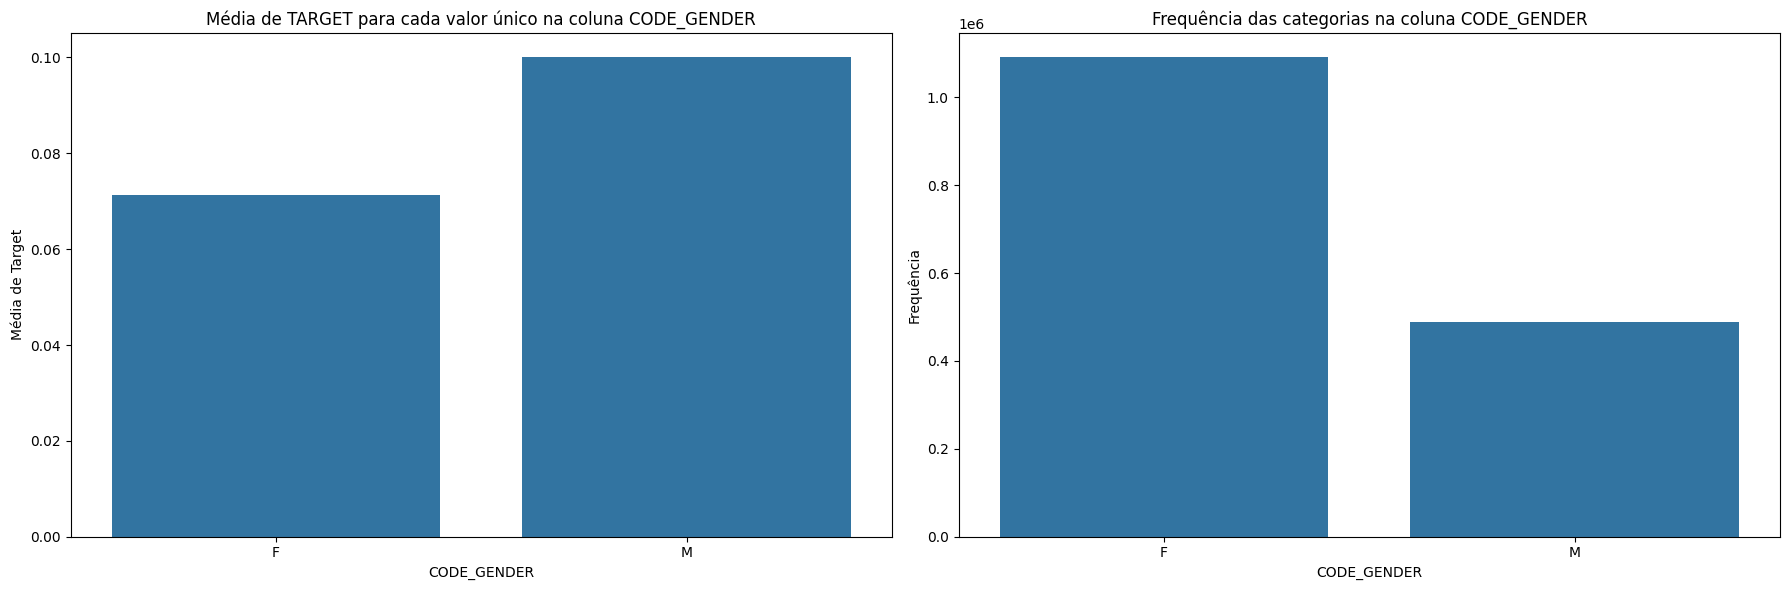

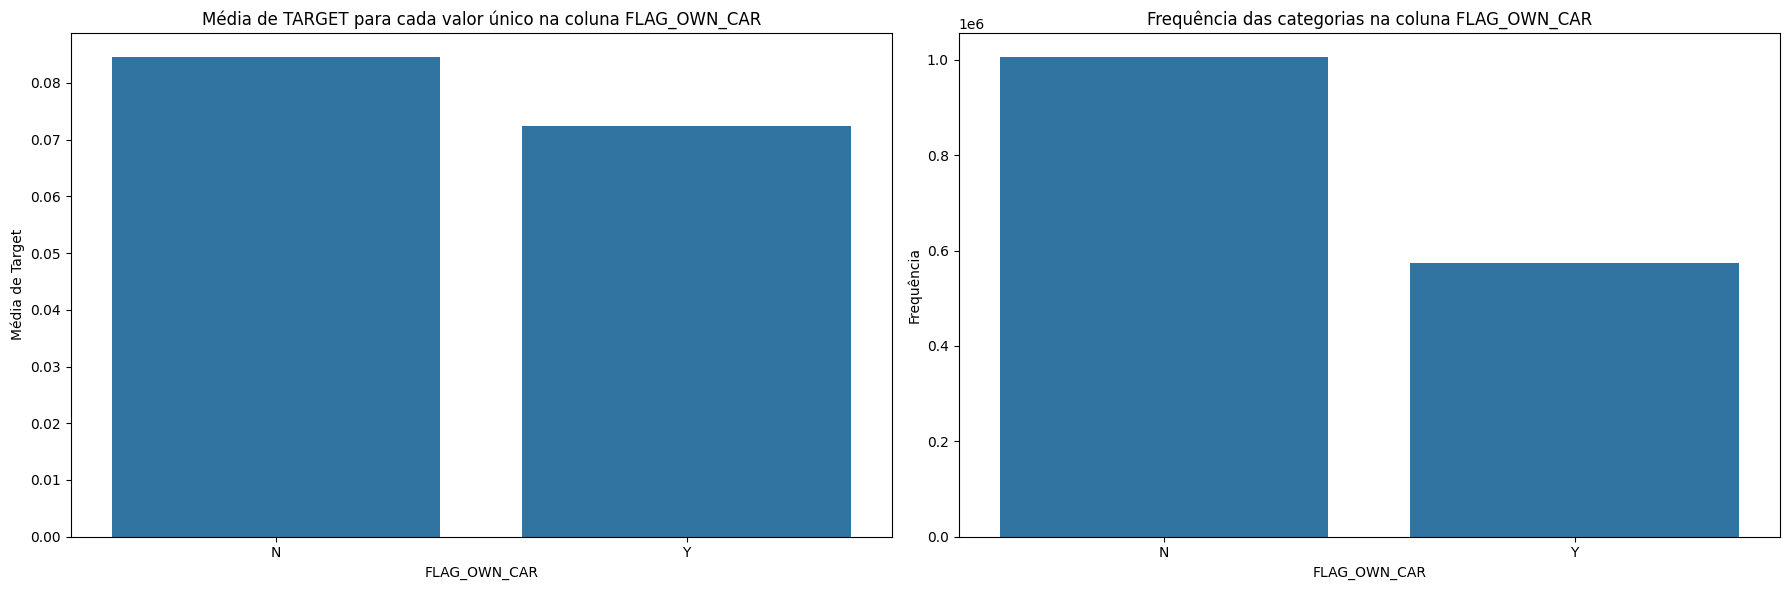

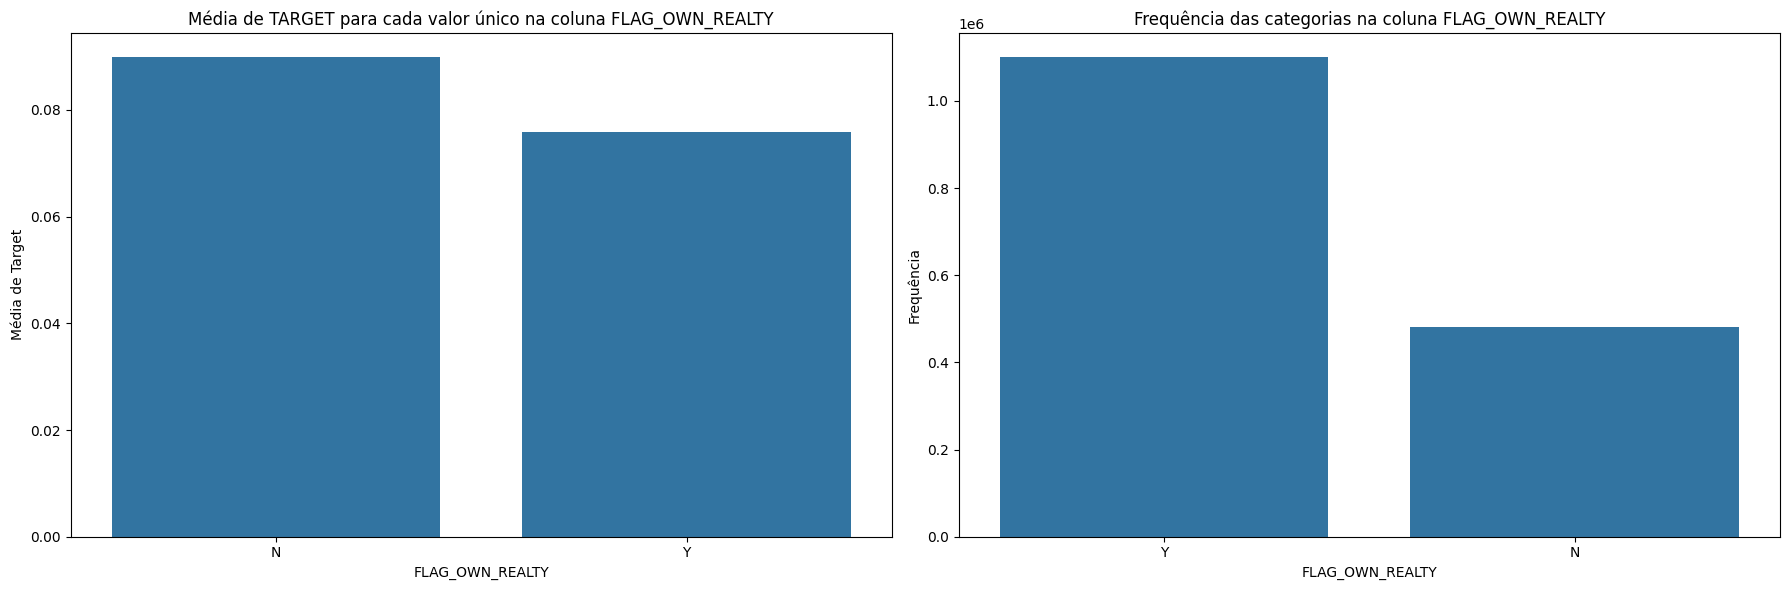

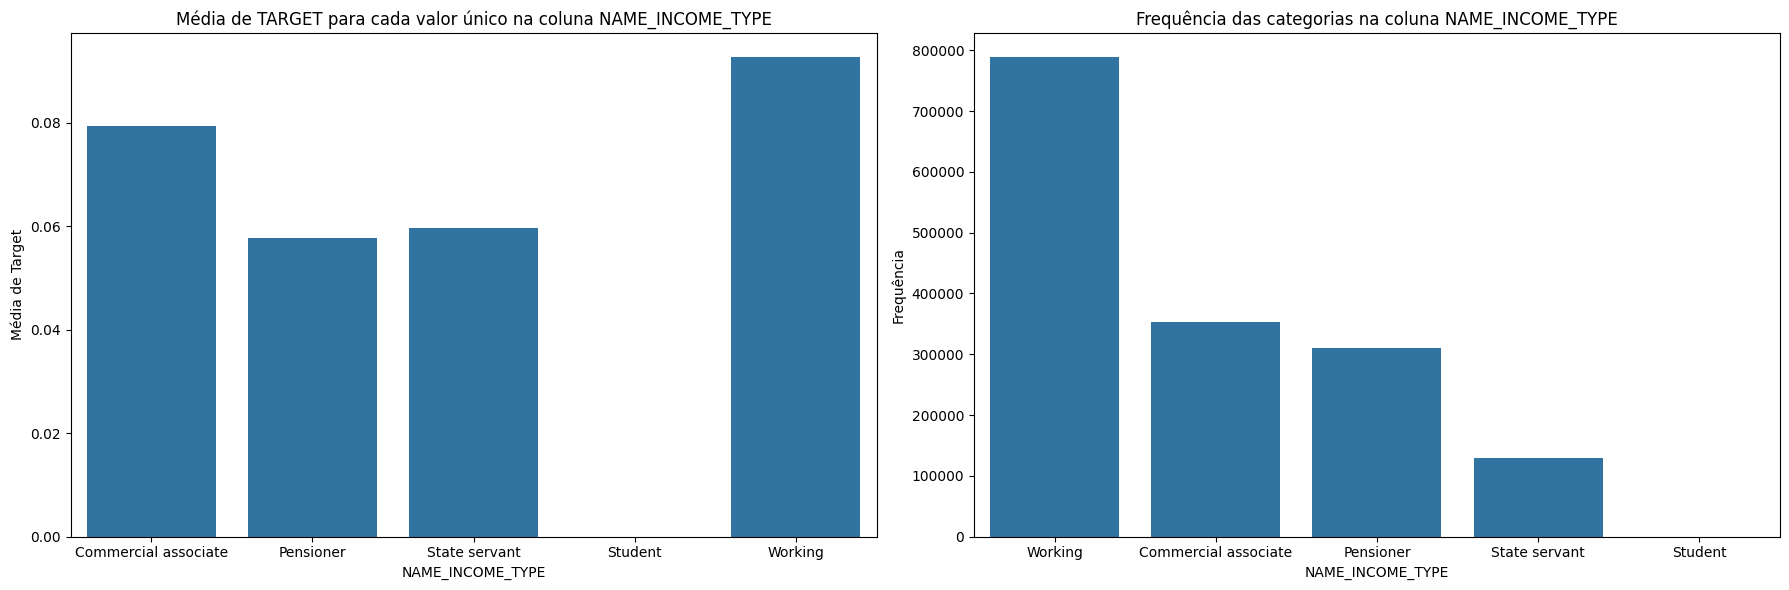

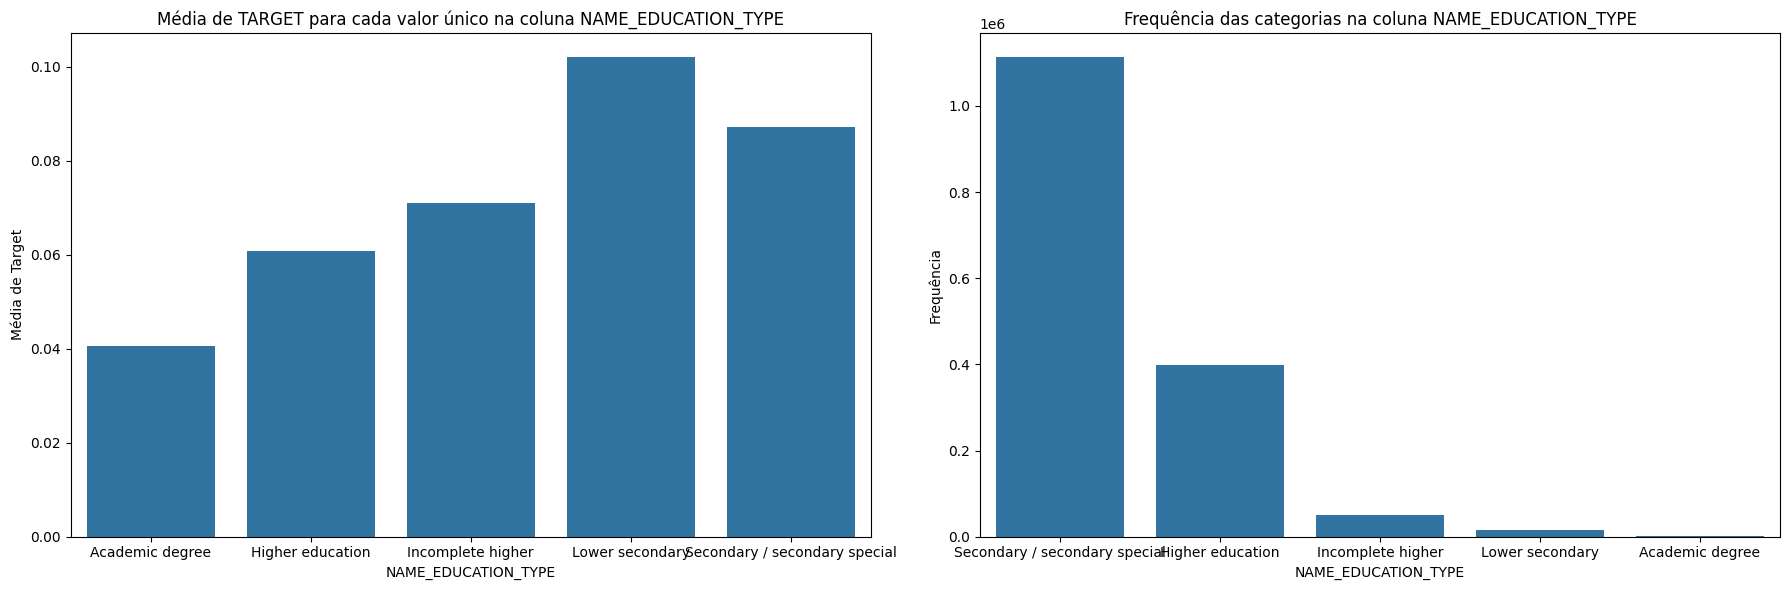

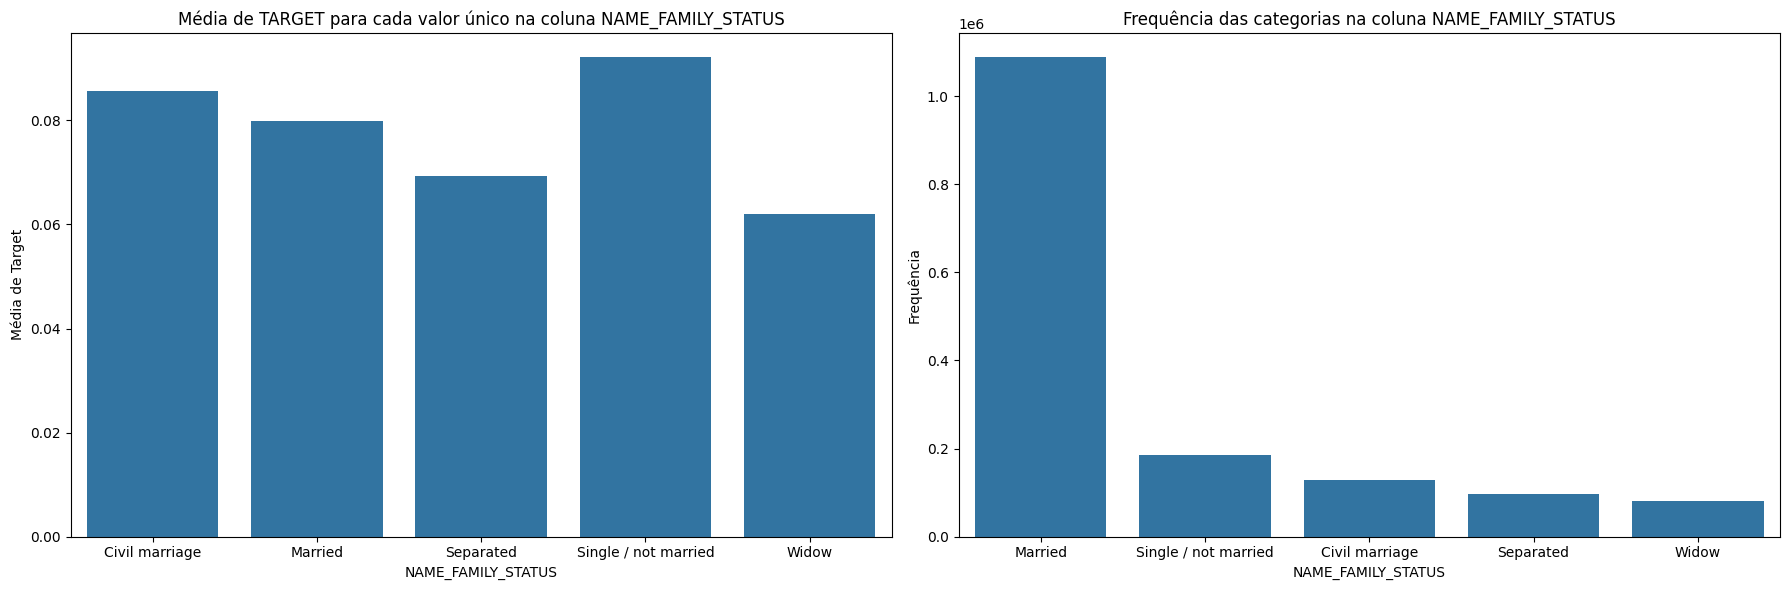

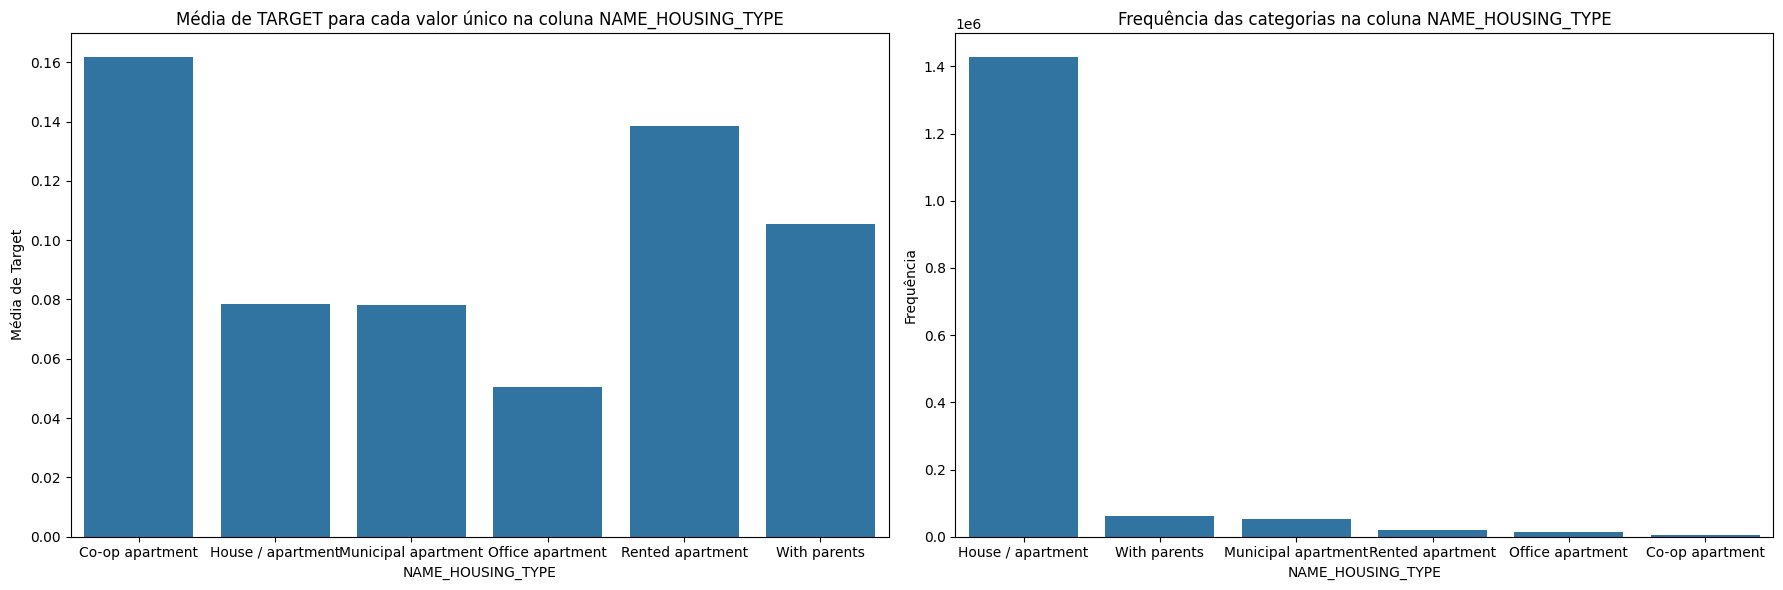

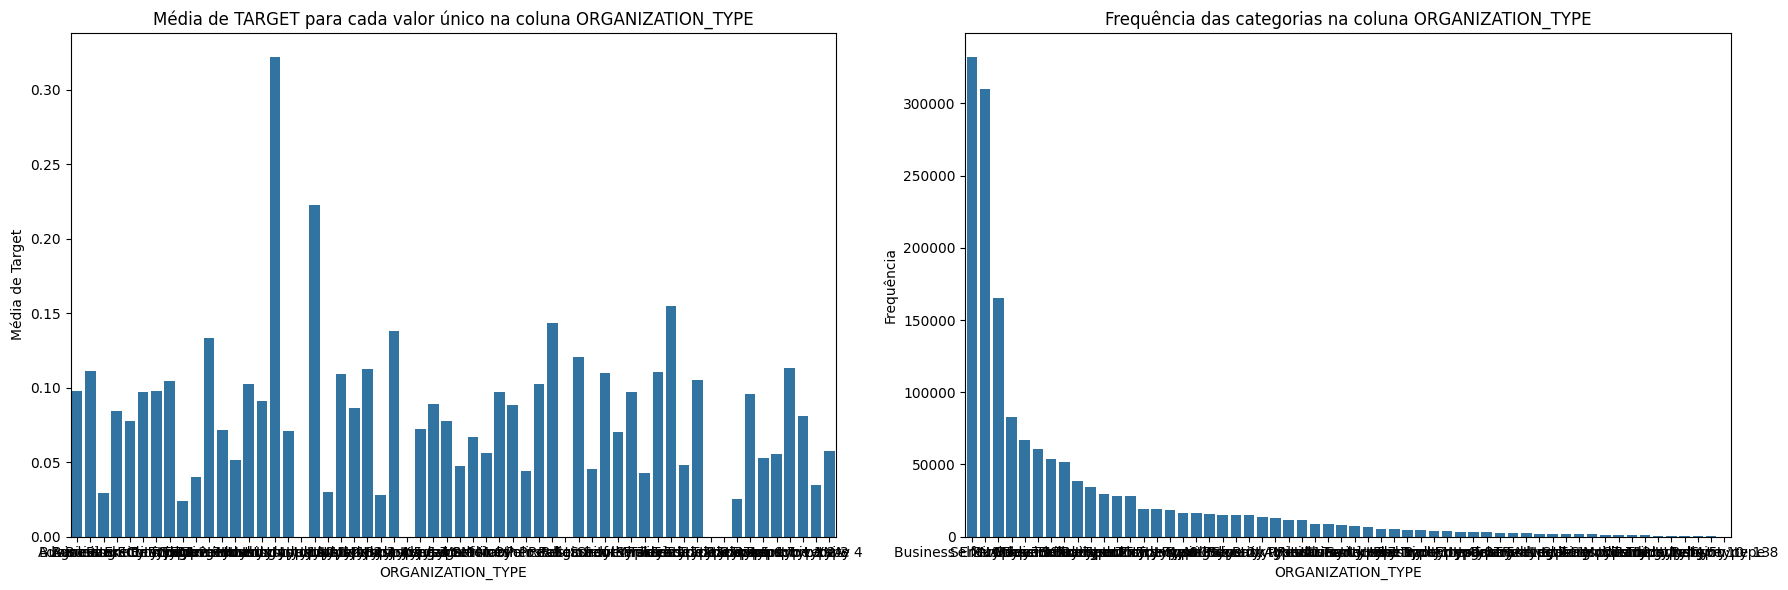

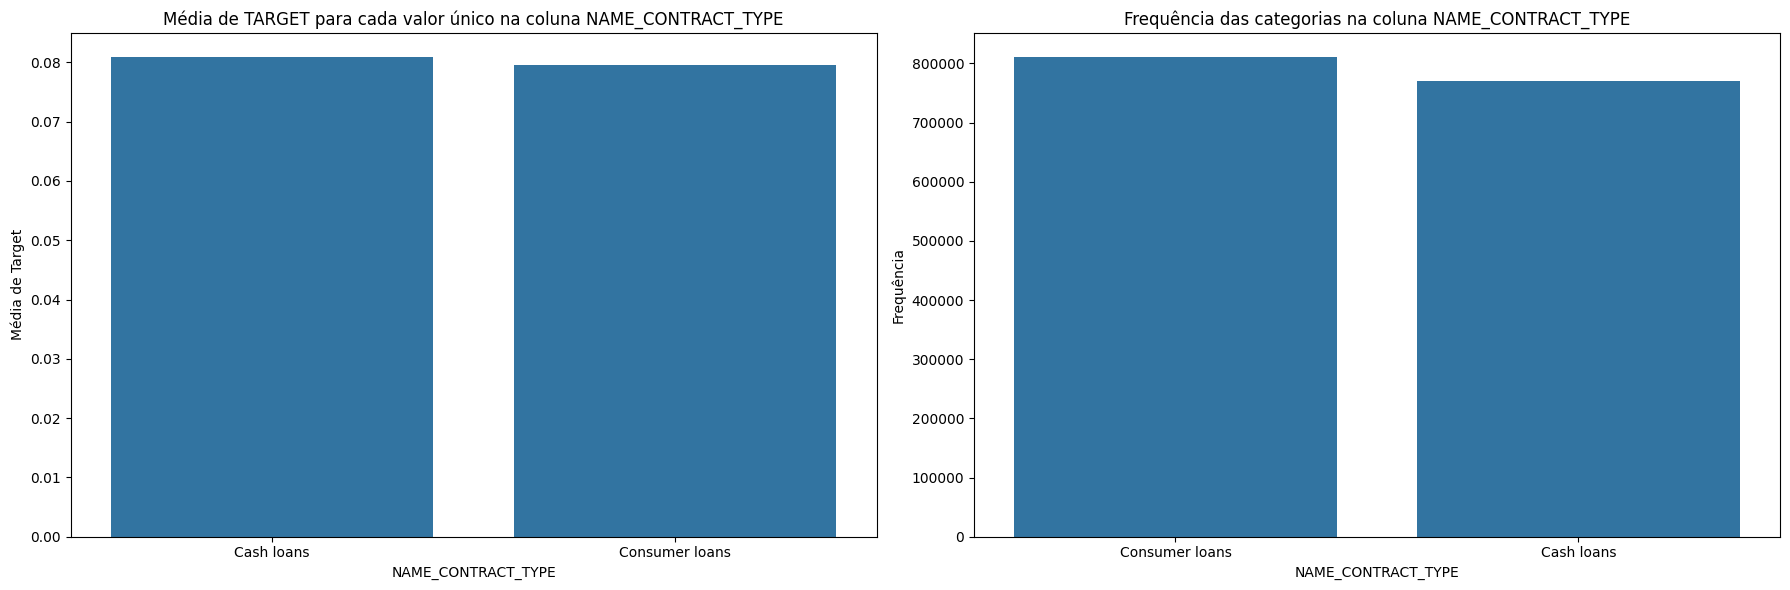

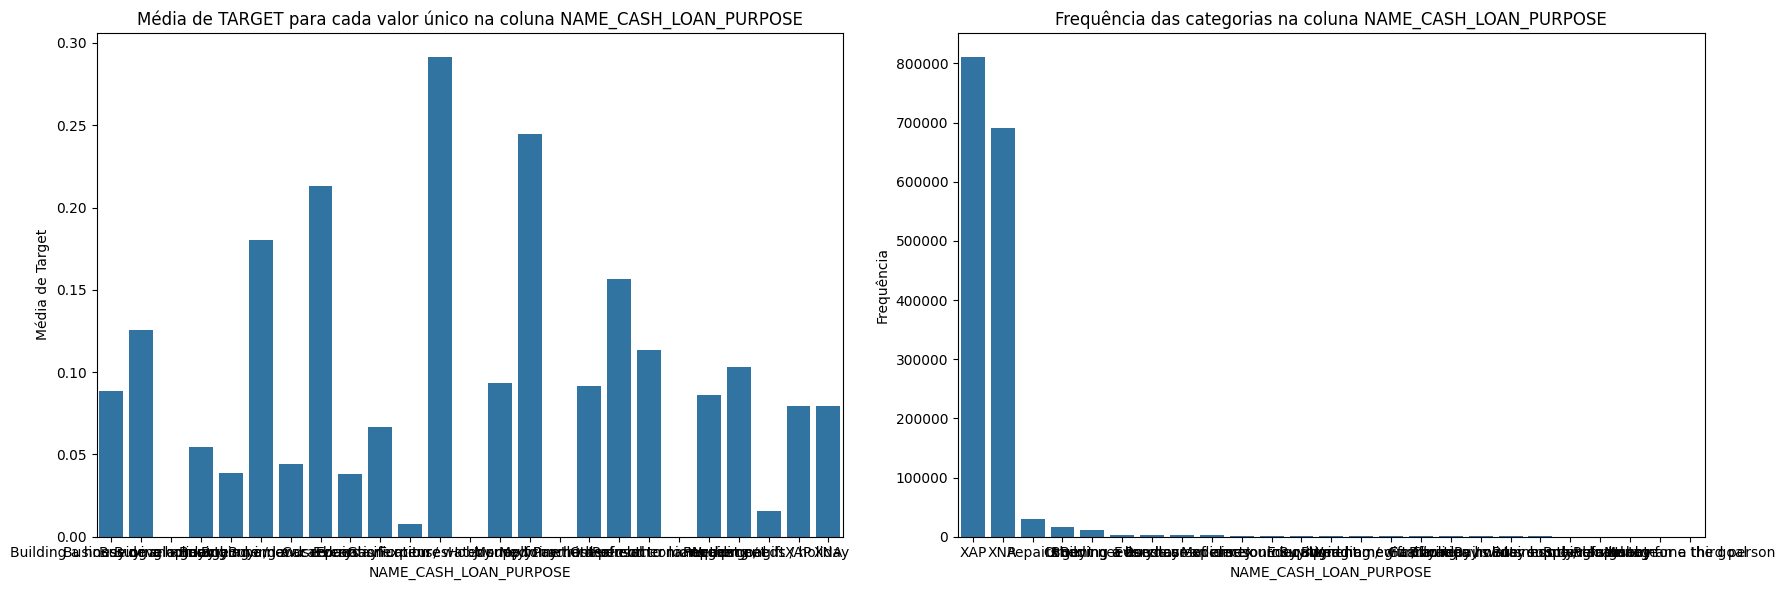

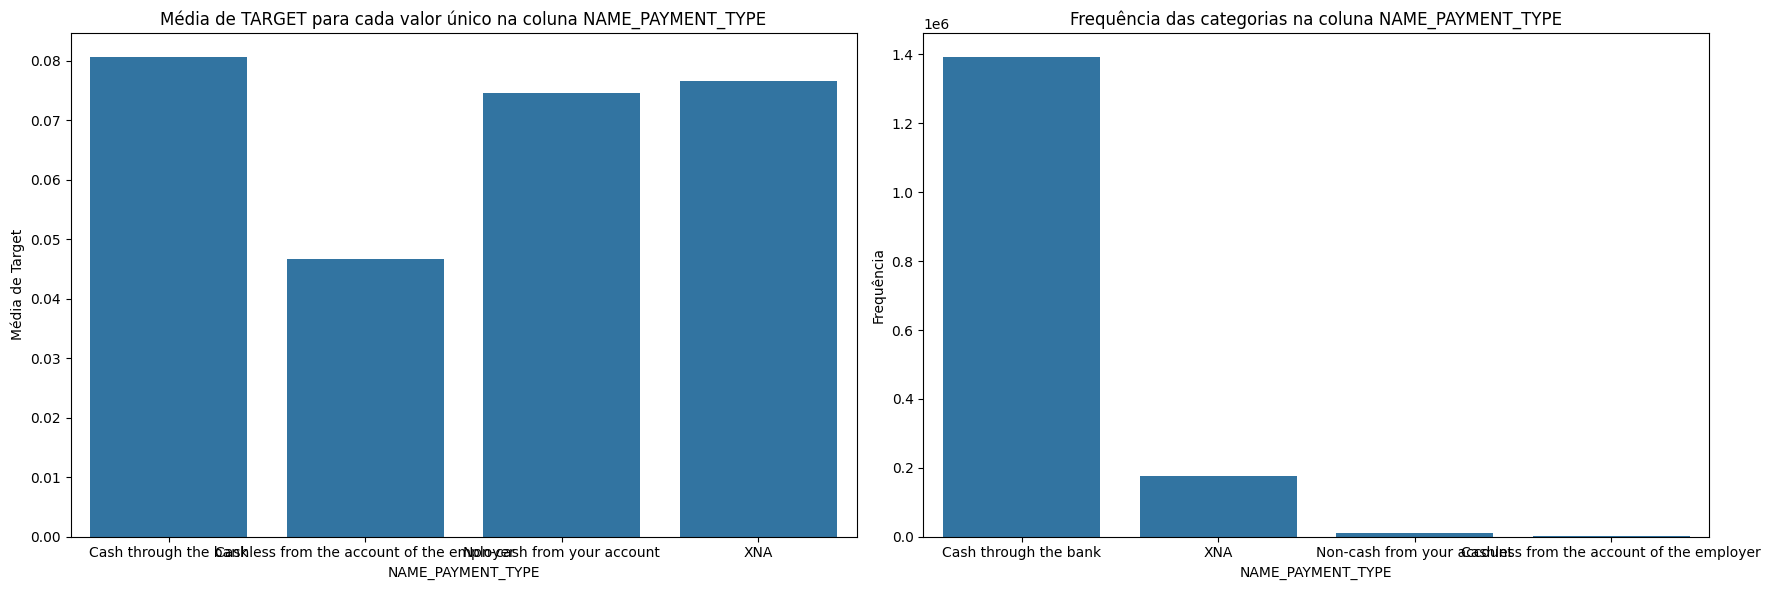

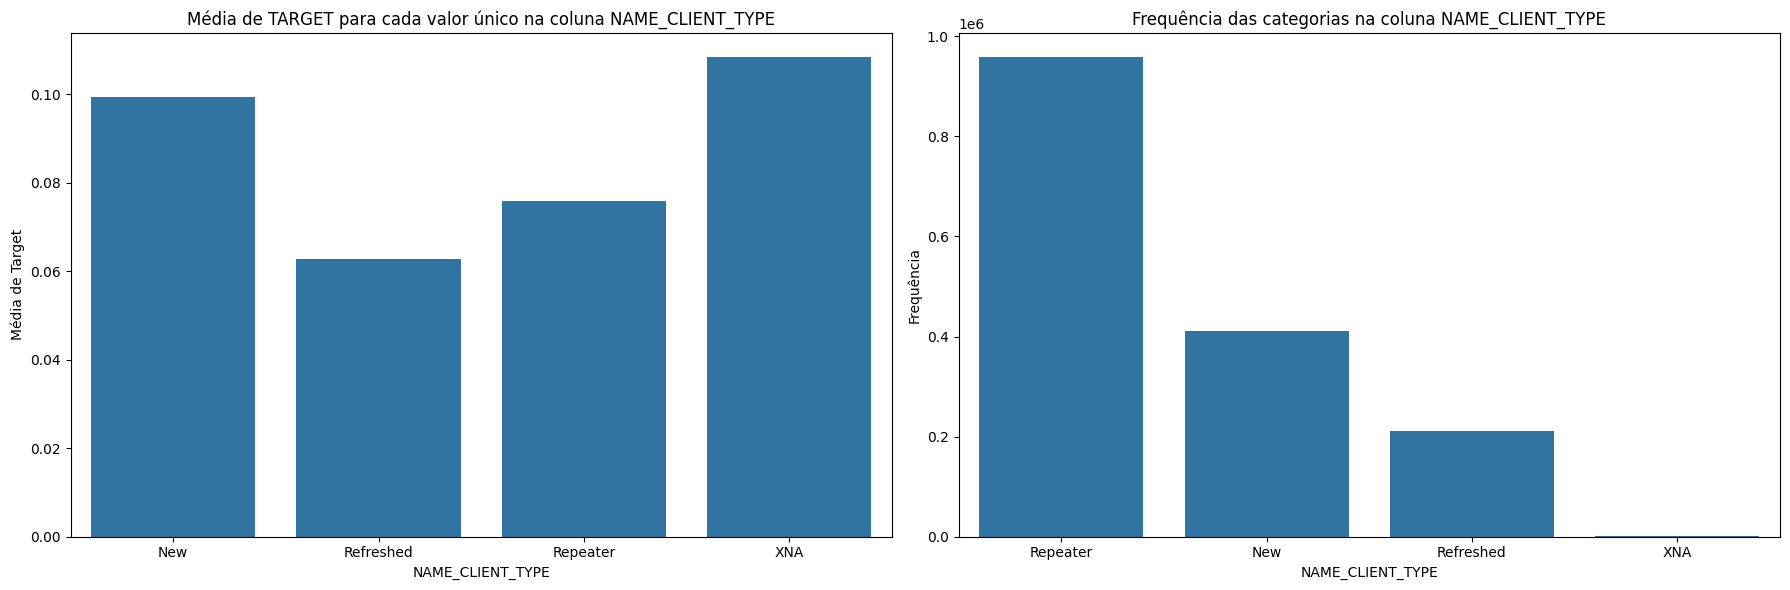

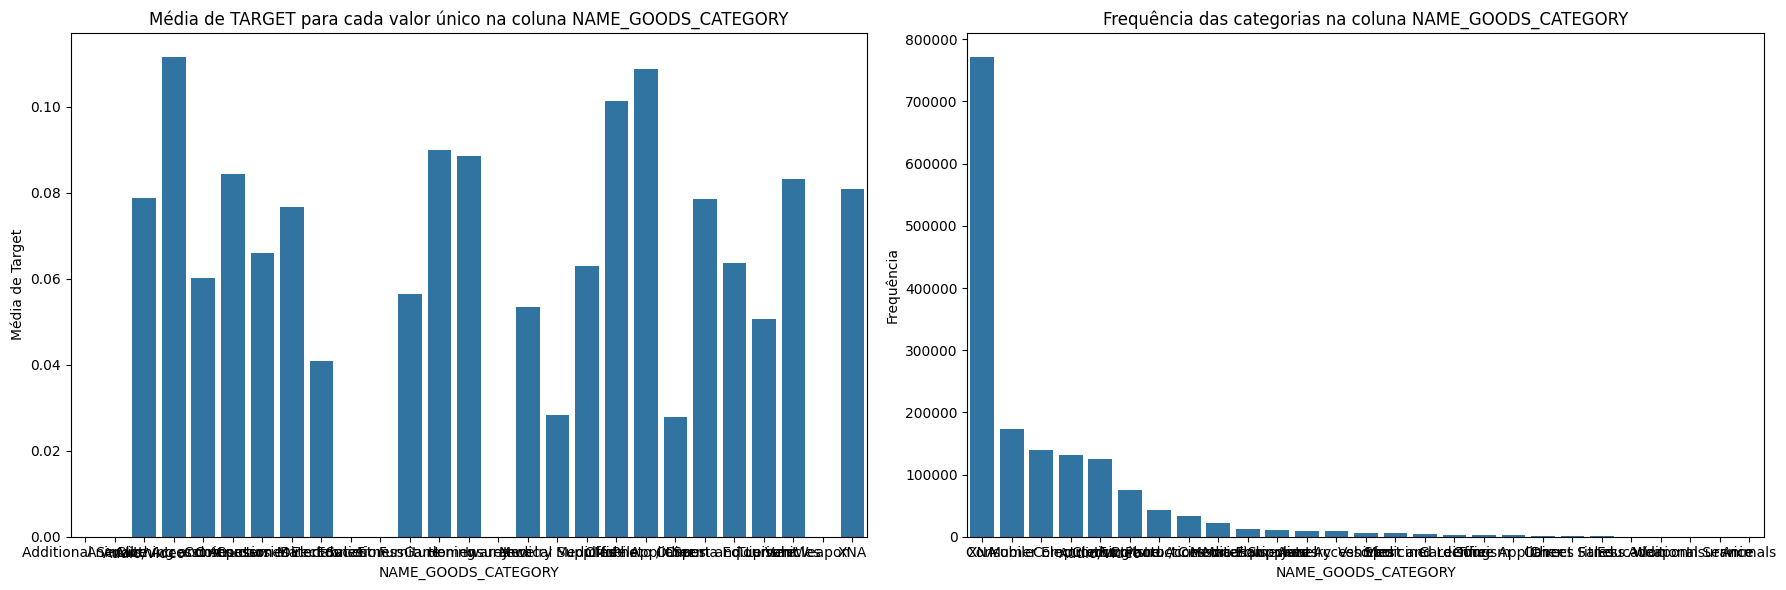

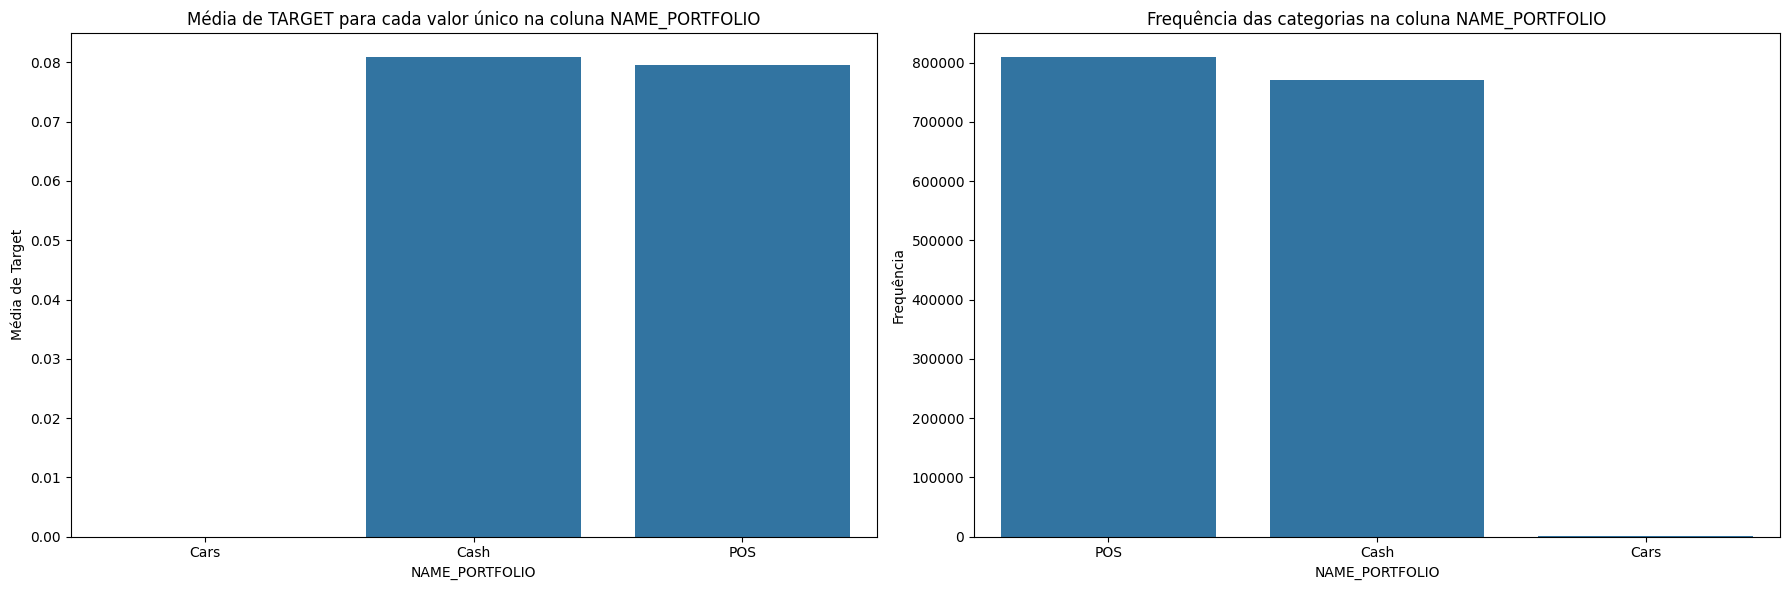

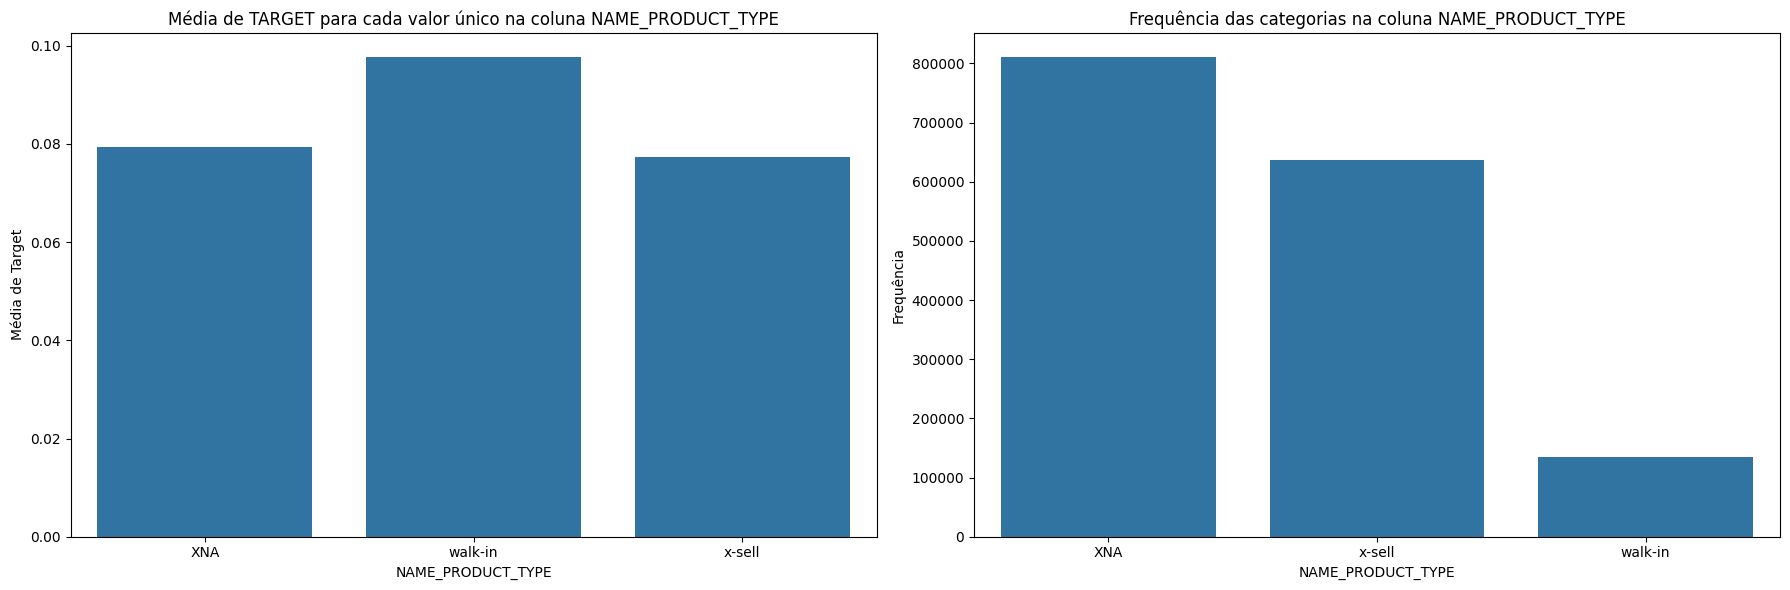

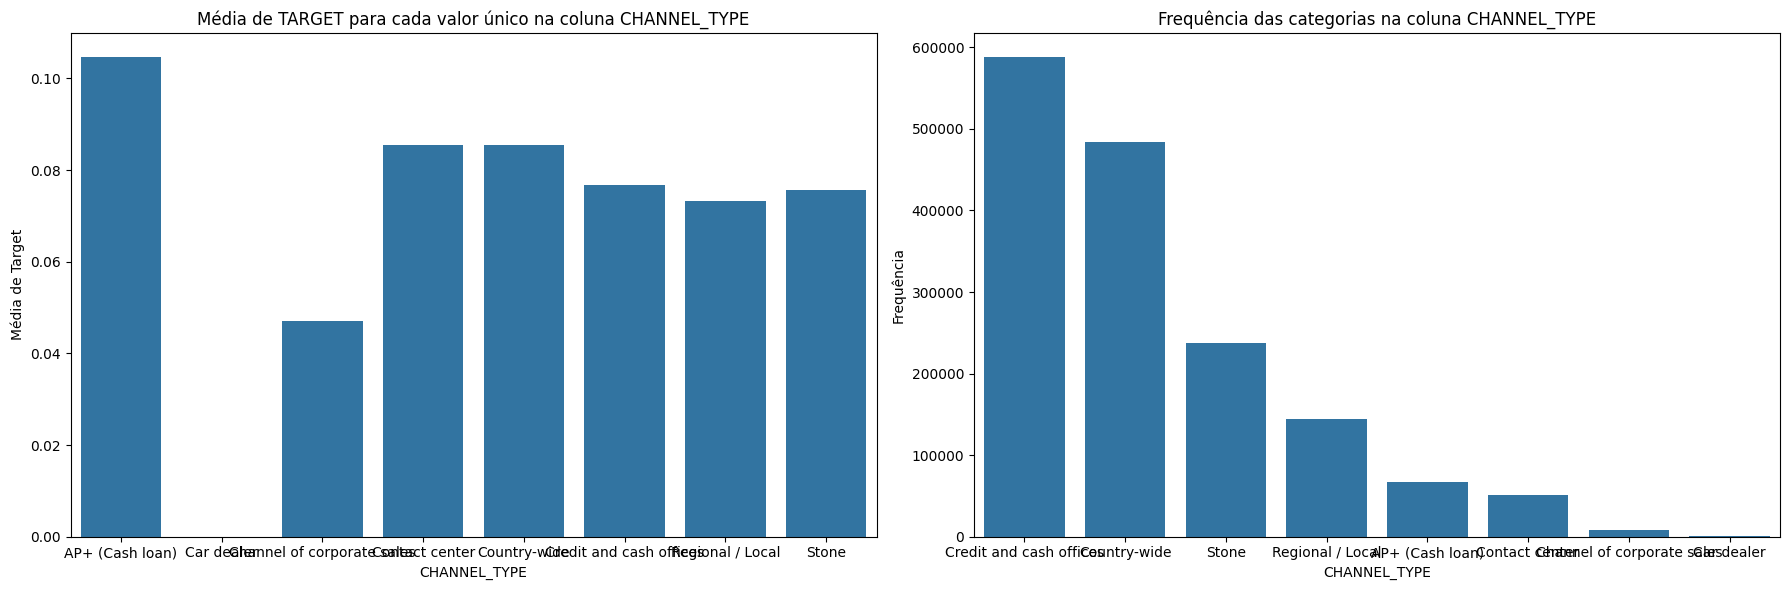

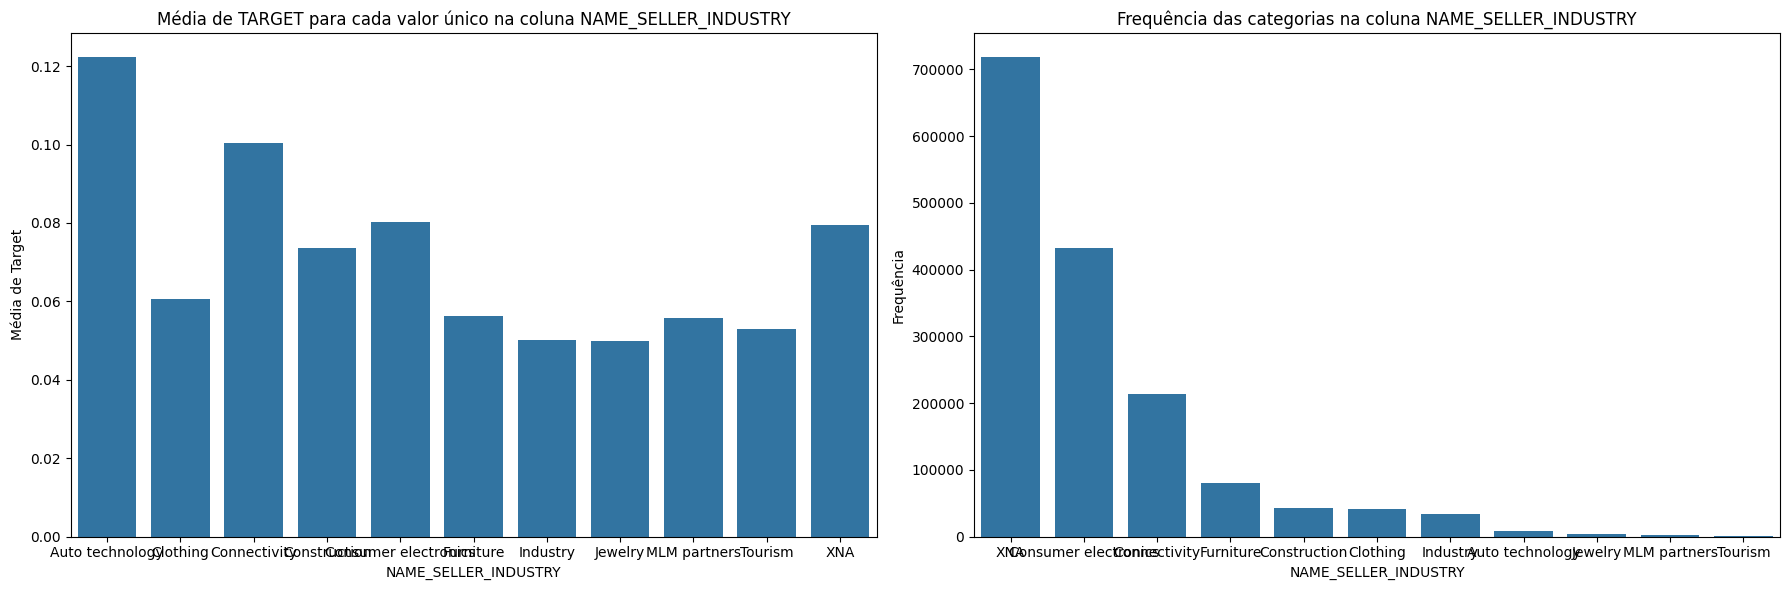

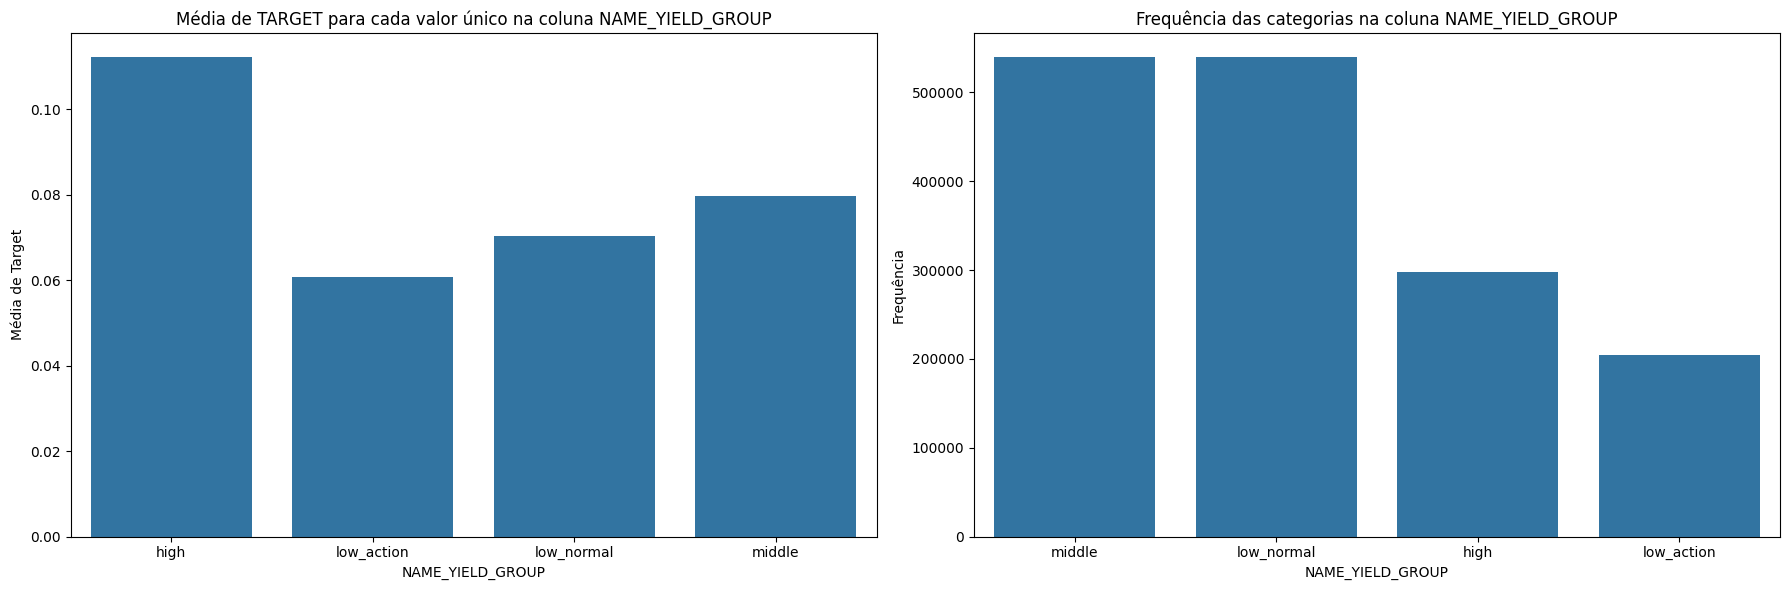

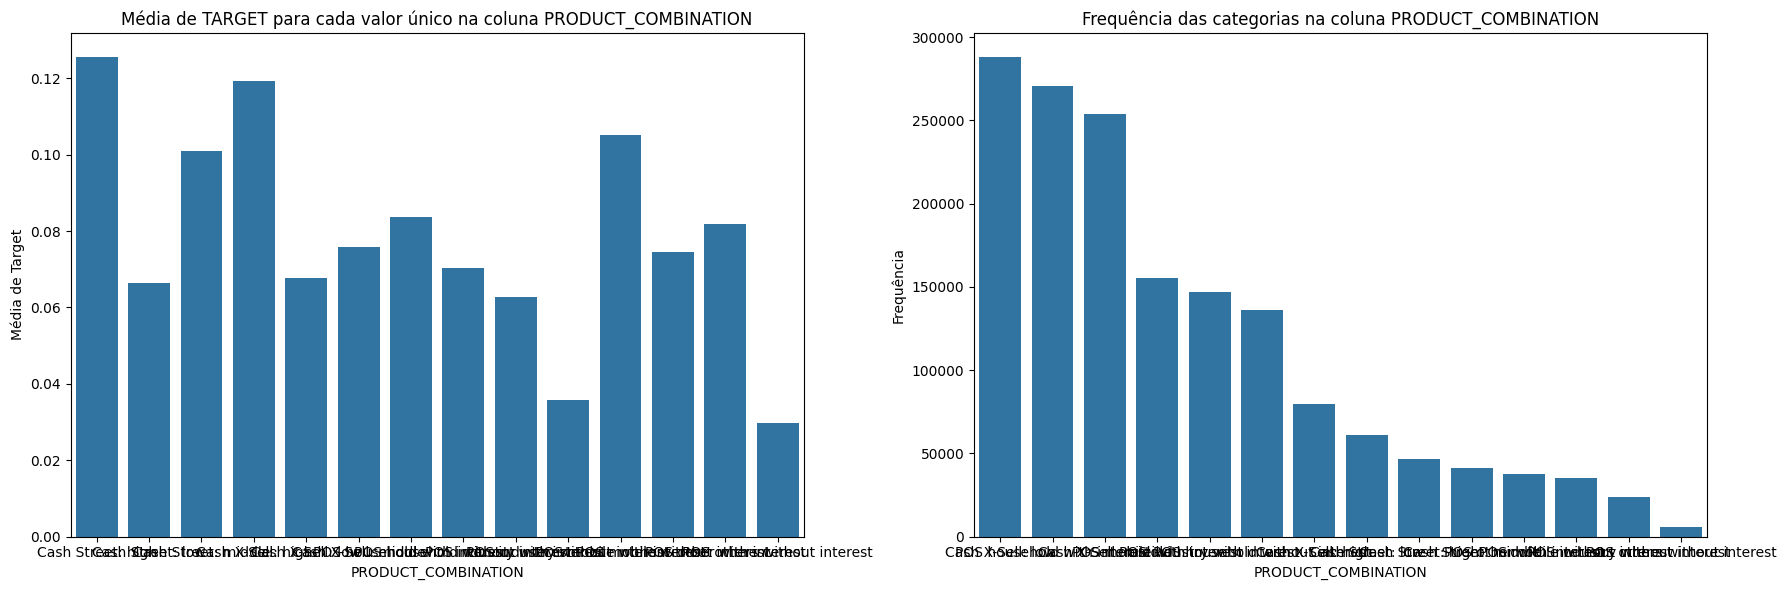

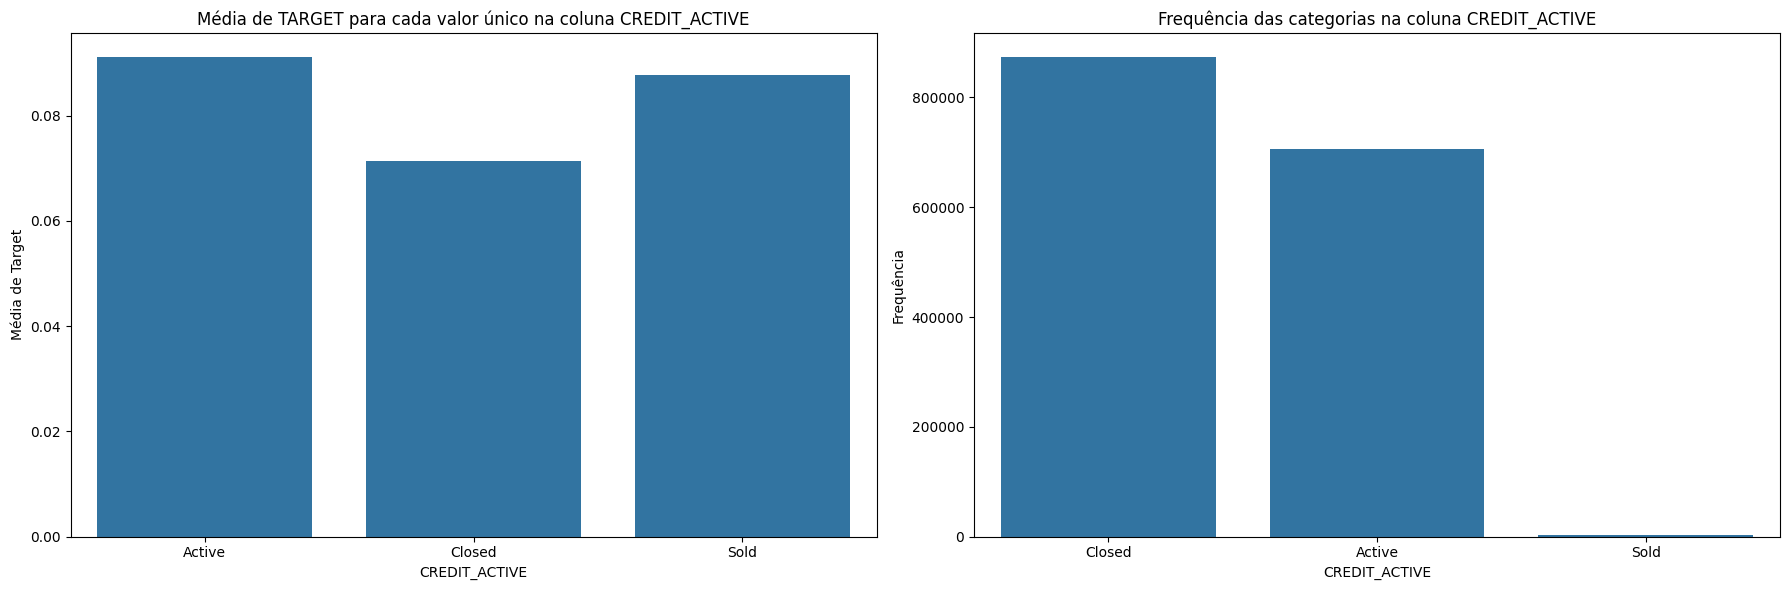

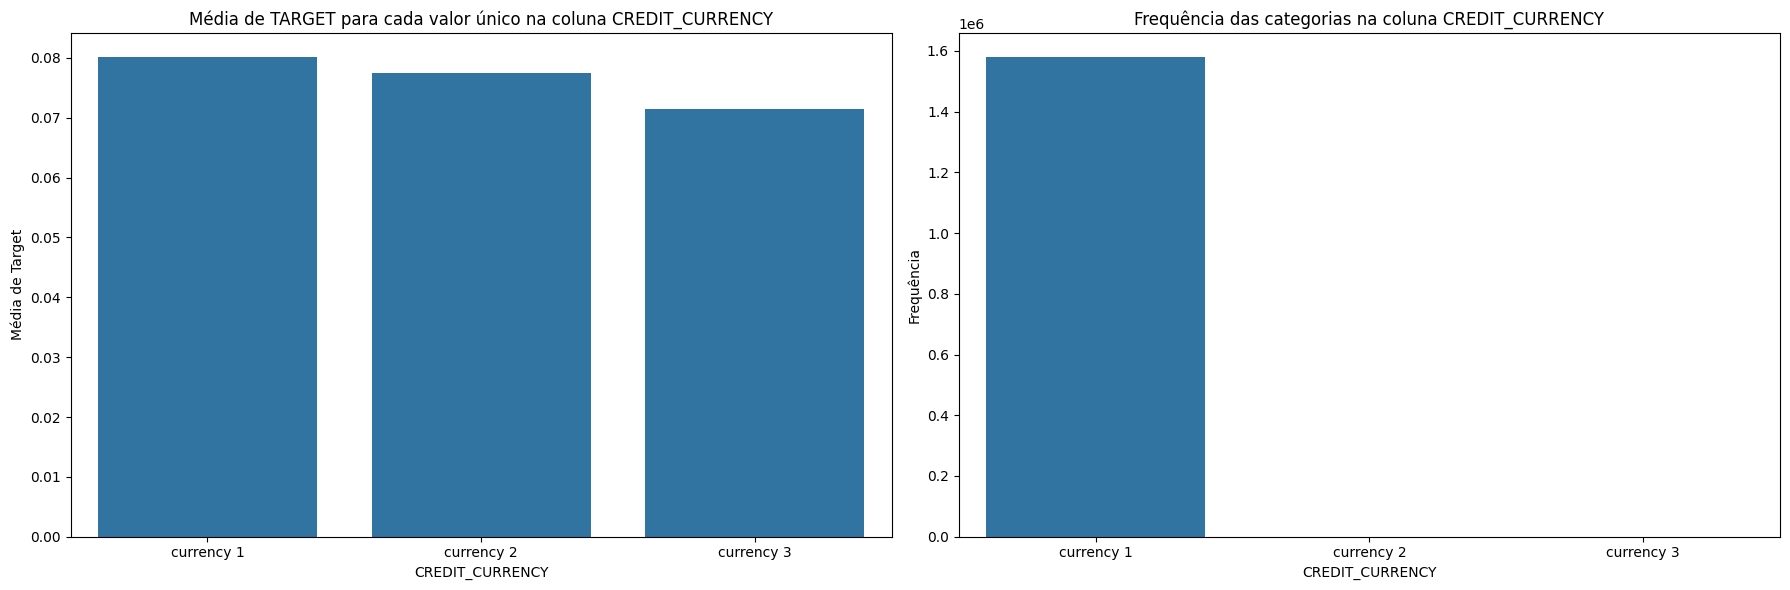

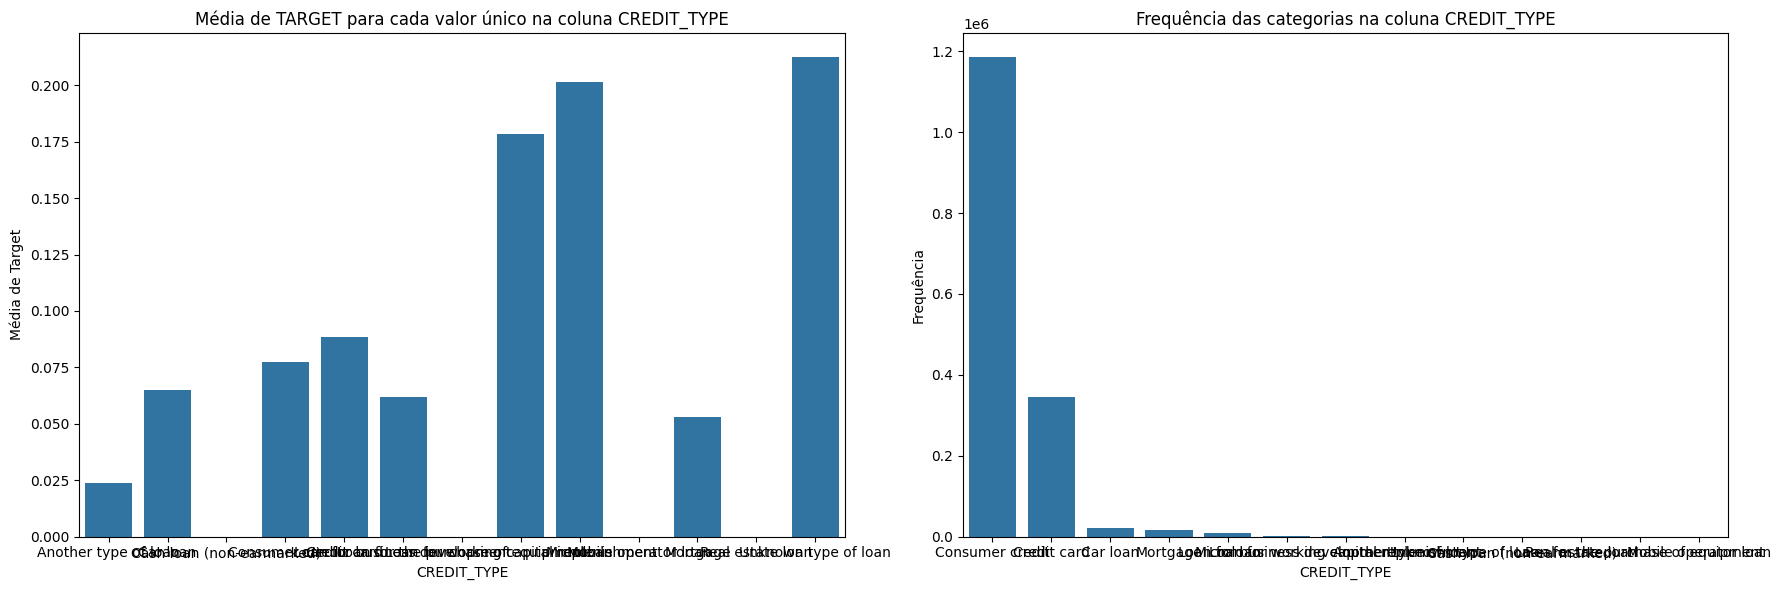

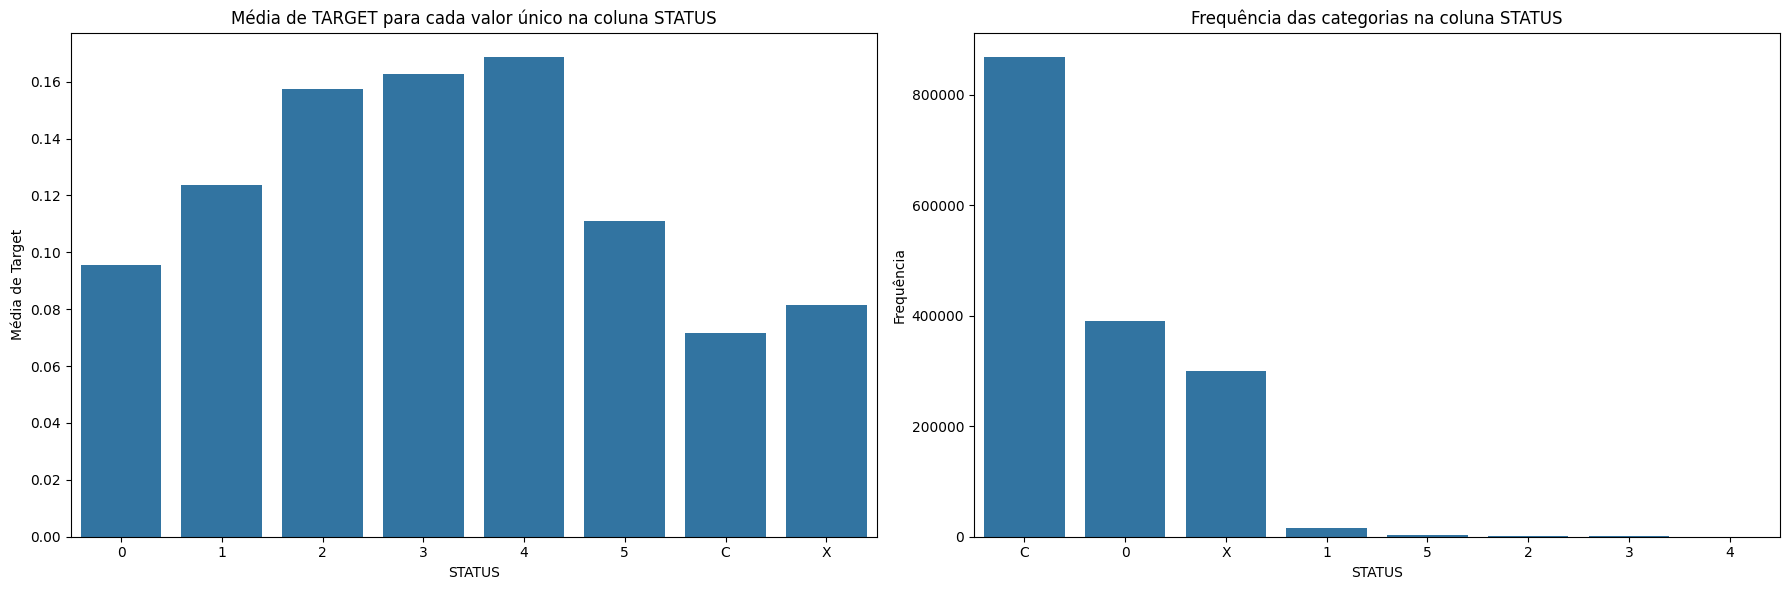

In [290]:
for col in train_df_f.select_dtypes(include=['object']).columns:
    mean_target = train_df_f.groupby(col)['TARGET'].mean().reset_index()
    freq_target = train_df_f[col].value_counts().reset_index()
    freq_target.columns = [col, 'Frequency']
    
    # Criar subplots lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot da média de Target
    sns.barplot(x=col, y='TARGET', data=mean_target, ax=axes[0])
    axes[0].set_title(f"Média de TARGET para cada valor único na coluna {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Média de Target')

    # Plot da frequência das categorias
    sns.barplot(x=col, y='Frequency', data=freq_target, ax=axes[1])
    axes[1].set_title(f"Frequência das categorias na coluna {col}")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frequência')

    plt.tight_layout()
    plt.show()

Podemos ver acima que há muitas colunas com distribuições desiguais. Além disso, a média de `TARGET` nesses valores únicos de algumas variáveis, pode nos fazer questionar o seu valor estatístico. Antes de prosseguir, vamos aplicar chi-quadrado nessas variáveis para saber se apresentam relevância para o nosso modelo.

In [291]:
from scipy.stats import chi2_contingency
# Função que realiza o teste de chi-quadrado para uma única variável categórica em relação à variável alvo
def chi2_test(df, feature, target):
    contingency_table = pd.crosstab(df[feature], df[target])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Função para aplicar chi2_test para todas as colunas categóricas
def apply_chi2_tests(df, target):
    alpha = 0.05
    categorical_columns = df.select_dtypes(include=['object']).columns

    results = {}
    for col in categorical_columns:
        chi2, p = chi2_test(df, col, target)
        results[col] = {
            'chi2': chi2,
            'p-value': p,
            'significant': p < alpha
        }
    
    return results


results = apply_chi2_tests(train_df_f, 'TARGET')

In [292]:
# Transformando 'results' em um DataFrame
chi2_results_df = pd.DataFrame(results).T
chi2_results_df.reset_index(inplace=True)
chi2_results_df.rename(columns={'index': 'Coluna'}, inplace=True)

chi2_results_df

,Coluna,chi2,p-value,significant
0,CODE_GENDER,3824.80,0.00,True
1,FLAG_OWN_CAR,730.05,0.00,True
2,FLAG_OWN_REALTY,896.42,0.00,True
3,NAME_INCOME_TYPE,4576.52,0.00,True
4,NAME_EDUCATION_TYPE,2955.66,0.00,True
5,NAME_FAMILY_STATUS,935.95,0.00,True
6,NAME_HOUSING_TYPE,2139.88,0.00,True
7,ORGANIZATION_TYPE,10272.65,0.00,True
8,NAME_CONTRACT_TYPE,11.33,0.00,True
9,NAME_CASH_LOAN_PURPOSE,1956.18,0.00,True


Podemos ver acima que a coluna `CREDIT_CURRENCY` não tem associação significativa com `TARGET`. Portanto, iremos eliminá-la.

In [293]:
train_df_fi = train_df_filt.drop(columns=['CREDIT_CURRENCY'])
test_df_fi = test_df_filt.drop(columns=['CREDIT_CURRENCY'])

Algumas colunas possuem uma distribuição de frequências não adequada. Há muitas variáveis que possuem valores únicos que representam menos de 5% dos casos, como é o caso de algumas variáveis mostradas abaixo. Assim, esses valores únicos precisam ser alterados para fazerem parte de alguma categoria maior.

In [294]:
train_df_fi['ORGANIZATION_TYPE'].value_counts()

ORGANIZATION_TYPE
Business Entity Type 3    332196
XNA                       309971
Self-employed             165104
Other                      82811
Medicine                   66819
Government                 60909
Business Entity Type 2     54073
School                     51452
Trade: type 7              38258
Kindergarten               34684
Construction               29684
Transport: type 4          28141
Business Entity Type 1     28073
Industry: type 9           18931
Industry: type 3           18885
Trade: type 3              18620
Housing                    16242
Transport: type 2          16204
Military                   15827
Police                     15322
Security                   15309
Bank                       15158
Industry: type 11          13490
Security Ministries        12660
Postal                     11414
Agriculture                11400
Restaurant                  8787
University                  8573
Industry: type 7            7803
Services                 

In [295]:
train_df_fi['STATUS'].value_counts()

STATUS
C    868886
0    390445
X    300899
1     15269
5      3823
2      1282
3       424
4       320
Name: count, dtype: int64

In [296]:
# Tratando as colunas

mapping = {
    'Business Entity Type 3': 'Business Entity',
    'Business Entity Type 2': 'Business Entity',
    'Business Entity Type 1': 'Business Entity',
    'XNA': 'Other',
    'Self-employed': 'Self-employed',
    'Other': 'Other',
    'Medicine': 'Healthcare',
    'Government': 'Government',
    'School': 'Education',
    'Kindergarten': 'Education',
    'Transport: type 4': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 3': 'Transport',
    'Transport: type 1': 'Transport',
    'Trade: type 7': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 2': 'Trade',
    'Trade: type 1': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 5': 'Trade',
    'Industry: type 3': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 11': 'Industry',
    'Industry: type 7': 'Industry',
    'Industry: type 1': 'Industry',
    'Industry: type 4': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 2': 'Industry',
    'Industry: type 6': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 12': 'Industry',
    'Industry: type 8': 'Industry',
    'Industry: type 13': 'Industry',
    'Housing': 'Real Estate',
    'Security': 'Security',
    'Military': 'Security',
    'Agriculture': 'Agriculture',
    'Postal': 'Postal',
    'Police': 'Security',
    'Security Ministries': 'Security',
    'Bank': 'Business Entity',
    'Restaurant': 'Food & Beverage',
    'University': 'Education',
    'Services': 'Services',
    'Electricity': 'Utilities',
    'Hotel': 'Hospitality',
    'Emergency': 'Healthcare',
    'Realtor': 'Real Estate',
    'Telecom': 'Telecom',
    'Insurance': 'Business Entity',
    'Culture': 'Other',
    'Advertising': 'Services',
    'Mobile': 'Telecom',
    'Legal Services': 'Services',
    'Cleaning': 'Other',
    'Religion': 'Other'
}

    
goods_category_map = {
    'Mobile': 'Electronics',
    'Consumer Electronics': 'Electronics',
    'Computers': 'Electronics',
    'Audio/Video': 'Electronics',
    'Photo / Cinema Equipment': 'Electronics',
    'Office Appliances': 'Electronics',
    'Medical Supplies': 'Healthcare',
    'Medicine': 'Healthcare',
    'Jewelry': 'Luxury Goods',
    'Vehicles': 'Automotive',
    'Auto Accessories': 'Automotive',
    'Gardening': 'Leisure',
    'Tourism': 'Leisure',
    'Sport and Leisure': 'Leisure',
    'Fitness': 'Healthcare',
    'Direct Sales': 'Other',
    'Education': 'Other',
    'Additional Service': 'Other',
    'Weapon': 'Other',
    'Furniture': 'Home & Living',
    'Clothing and Accessories': 'Luxury Goods',
    'Construction Materials': 'Construction',
    'Homewares': 'Home & Living',
    'Other': 'Other'
}

def preprocess_categorical(df):
    df.loc[:, 'STATUS'] = df['STATUS'].apply(lambda x: 'Regular' if x in ['C', '0'] else 'Problemático')
    
    df.loc[:, 'CREDIT_ACTIVE'] = df['CREDIT_ACTIVE'].replace({'Sold': 'Active'})
    
    df.loc[:, 'NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].replace({
        'Incomplete higher': 'Higher education',
        'Academic degree': 'Higher education',
        'Lower secondary': 'Secondary / secondary special'
    })
    
    df.loc[:, 'CHANNEL_TYPE'] = df['CHANNEL_TYPE'].apply(
        lambda x: x if x in ['Credit and cash offices', 'Country-wide'] else 'Other'
    )
    
    df.loc[:, 'NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].apply(
        lambda x: x if x in ['House / apartment', 'With parents'] else 'Other'
    )
    
    df = df[df['NAME_CLIENT_TYPE'] != 'XNA']
    
    df.loc[:, 'NAME_PAYMENT_TYPE'] = df['NAME_PAYMENT_TYPE'].apply(
        lambda x: x if x in ['Cash through the bank'] else 'Other'
    )
    
    df.loc[:, 'NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].replace({
        'Pensioner': 'Pensioner/Student',
        'Student': 'Pensioner/Student',
    })
    
    df.loc[:, 'NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].replace({
        'Married': 'Married',
        'Civil marriage': 'Married',
        'Single / not married': 'Not Married',
    })
    
    df.loc[:, 'ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(mapping)
    
    df.loc[:, 'NAME_GOODS_CATEGORY'] = df['NAME_GOODS_CATEGORY'].map(goods_category_map).fillna('Other')
    
    df.loc[:, 'NAME_SELLER_INDUSTRY'] = df['NAME_SELLER_INDUSTRY'].replace({
        'Consumer electronics': 'Electronics',
        'Connectivity': 'Electronics',
        'Auto technology': 'Electronics',
        'Jewelry': 'Luxury Goods',
        'Clothing': 'Luxury Goods',
        'MLM partners': 'Other',
        'Tourism': 'Other',
        'Industry': 'Other'
    })
    
    return df


Decidi remover a coluna `NAME_CASH_LOAN_PURPOSE`. O desequilíbrio entre as variáveis é muito grande e, além disso, as duas principais categorias são um mistério ('XAP', 'XNA'), provavelmente significam algo como "não definido/aplicável". 

In [297]:
train_df_fi['NAME_CASH_LOAN_PURPOSE'].value_counts()

NAME_CASH_LOAN_PURPOSE
XAP                                 811067
XNA                                 690744
Repairs                              30005
Other                                16460
Urgent needs                         10710
Buying a used car                     3497
Building a house or an annex          3185
Everyday expenses                     2512
Medicine                              2351
Purchase of electronic equipment      1695
Journey                               1320
Education                             1250
Buying a home                         1112
Buying a new car                      1091
Wedding / gift / holiday              1027
Furniture                              807
Car repairs                            747
Gasification / water supply            511
Buying a holiday home / land           478
Payments on other loans                421
Business development                   199
Buying a garage                        109
Hobby                          

In [298]:
train_df_fi = train_df_filt.drop(columns=['NAME_CASH_LOAN_PURPOSE'])
test_df_fi = test_df_filt.drop(columns=['NAME_CASH_LOAN_PURPOSE'])

In [299]:
train_df = preprocess_categorical(train_df_fi)

In [300]:
test_df = preprocess_categorical(test_df_fi)

In [301]:
train_df['PRODUCT_COMBINATION'].value_counts()

PRODUCT_COMBINATION
Cash X-Sell: low                  288140
POS household with interest       270294
Cash X-Sell: middle               253758
POS mobile with interest          155212
POS industry with interest        146659
POS household without interest    136045
Cash X-Sell: high                  79461
Cash Street: low                   61206
Cash Street: high                  46608
Cash Street: middle                41023
POS other with interest            37473
POS mobile without interest        34997
POS industry without interest      23558
POS others without interest         6084
Name: count, dtype: int64

Agora, um olhar mais atento sobre `PRODUCT_COMBINATION`. Podemos notar a repetição da palavra _interest_, ou seja, juros. Talvez o conteúdo mais valioso dessa coluna seja a aplicação ou não de juros. A princípio, estranhei um empréstimo não envovler juros, mas vi que é possível, em casos de organizações ou programas voltados para assisência. 

Se criarmos uma coluna binária a partir dessa coluna indicando 1 para a aplicação de juros e 0 para a não aplicação de juros, ficaremos com quase 50% para cada valor único, uma medida muito boa. Assim, essa será a estratégia adotada, ao mesmo tempo que deletarei a coluna original.

In [302]:
def creating_has_interest(dfi):
    df = dfi.copy()  
    df['HAS_INTEREST'] = df['PRODUCT_COMBINATION'].apply(lambda x: 1 if 'interest' in x else 0)
    df = df.drop(columns=['PRODUCT_COMBINATION'])
    return df

In [303]:
train_int = creating_has_interest(train_df)
test_int = creating_has_interest(test_df)

Abaixo podemos ver que há uma grande expressividade desse dado no dataframe.

In [304]:
train_int['HAS_INTEREST'].value_counts()

HAS_INTEREST
1    810322
0    770196
Name: count, dtype: int64

### 2.3.4. Calculando Novamente Multicolinearidade Após a Inserção de `HAS_INTEREST`

Agora que adicionamos uma nova coluna numérica (`HAS_INTEREST`), certamente precisamos verificar novamente se geramos multicolinearidade.

In [305]:
cl_numb = train_int.select_dtypes(include=['number'])
X_sample = cl_numb.drop(columns=['TARGET'])

vif_after_has = calculate_vif(X_sample)

vif_after_has

,Variable,VIF
0,AMT_INCOME_TOTAL,4.86
1,AMT_CREDIT,154.08
2,AMT_GOODS_PRICE,147.88
3,DAYS_BIRTH,28.05
4,DAYS_EMPLOYED,2.09
5,DAYS_REGISTRATION,3.35
6,DAYS_ID_PUBLISH,5.98
7,DAYS_LAST_PHONE_CHANGE,3.06
8,AMT_APPLICATION,3.17
9,DAYS_LAST_DUE_1ST_VERSION,1.51


In [306]:
df_no_mult = remove_high_vif_features(X_sample, vif_threshold=10)

Removendo variável 'AMT_CREDIT' com VIF = 154.08291922986893
Removendo variável 'SK_ID_BUREAU' com VIF = 29.04022385583379
Removendo variável 'DAYS_BIRTH' com VIF = 15.053787128998435


Removendo as colunas dos dataframes de teste e treino:

In [307]:
columns_to_remove = [
    'AMT_CREDIT',
    'SK_ID_BUREAU',
    'DAYS_BIRTH'
]

train_no_mult = train_int.drop(columns=columns_to_remove)
test_no_mult = test_int.drop(columns=columns_to_remove)

In [308]:
train_no_mult.shape

(1580518, 35)

# 2.4. Outliers

In [309]:
n = train_no_mult.select_dtypes(include=['number'])

In [310]:
n.columns

Index(['TARGET', 'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_APPLICATION', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_CREDIT',
       'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_OVERDUE',
       'HAS_INTEREST'],
      dtype='object')

Alguns outliers que merecem atenção estão representados nos boxplots abaixo:

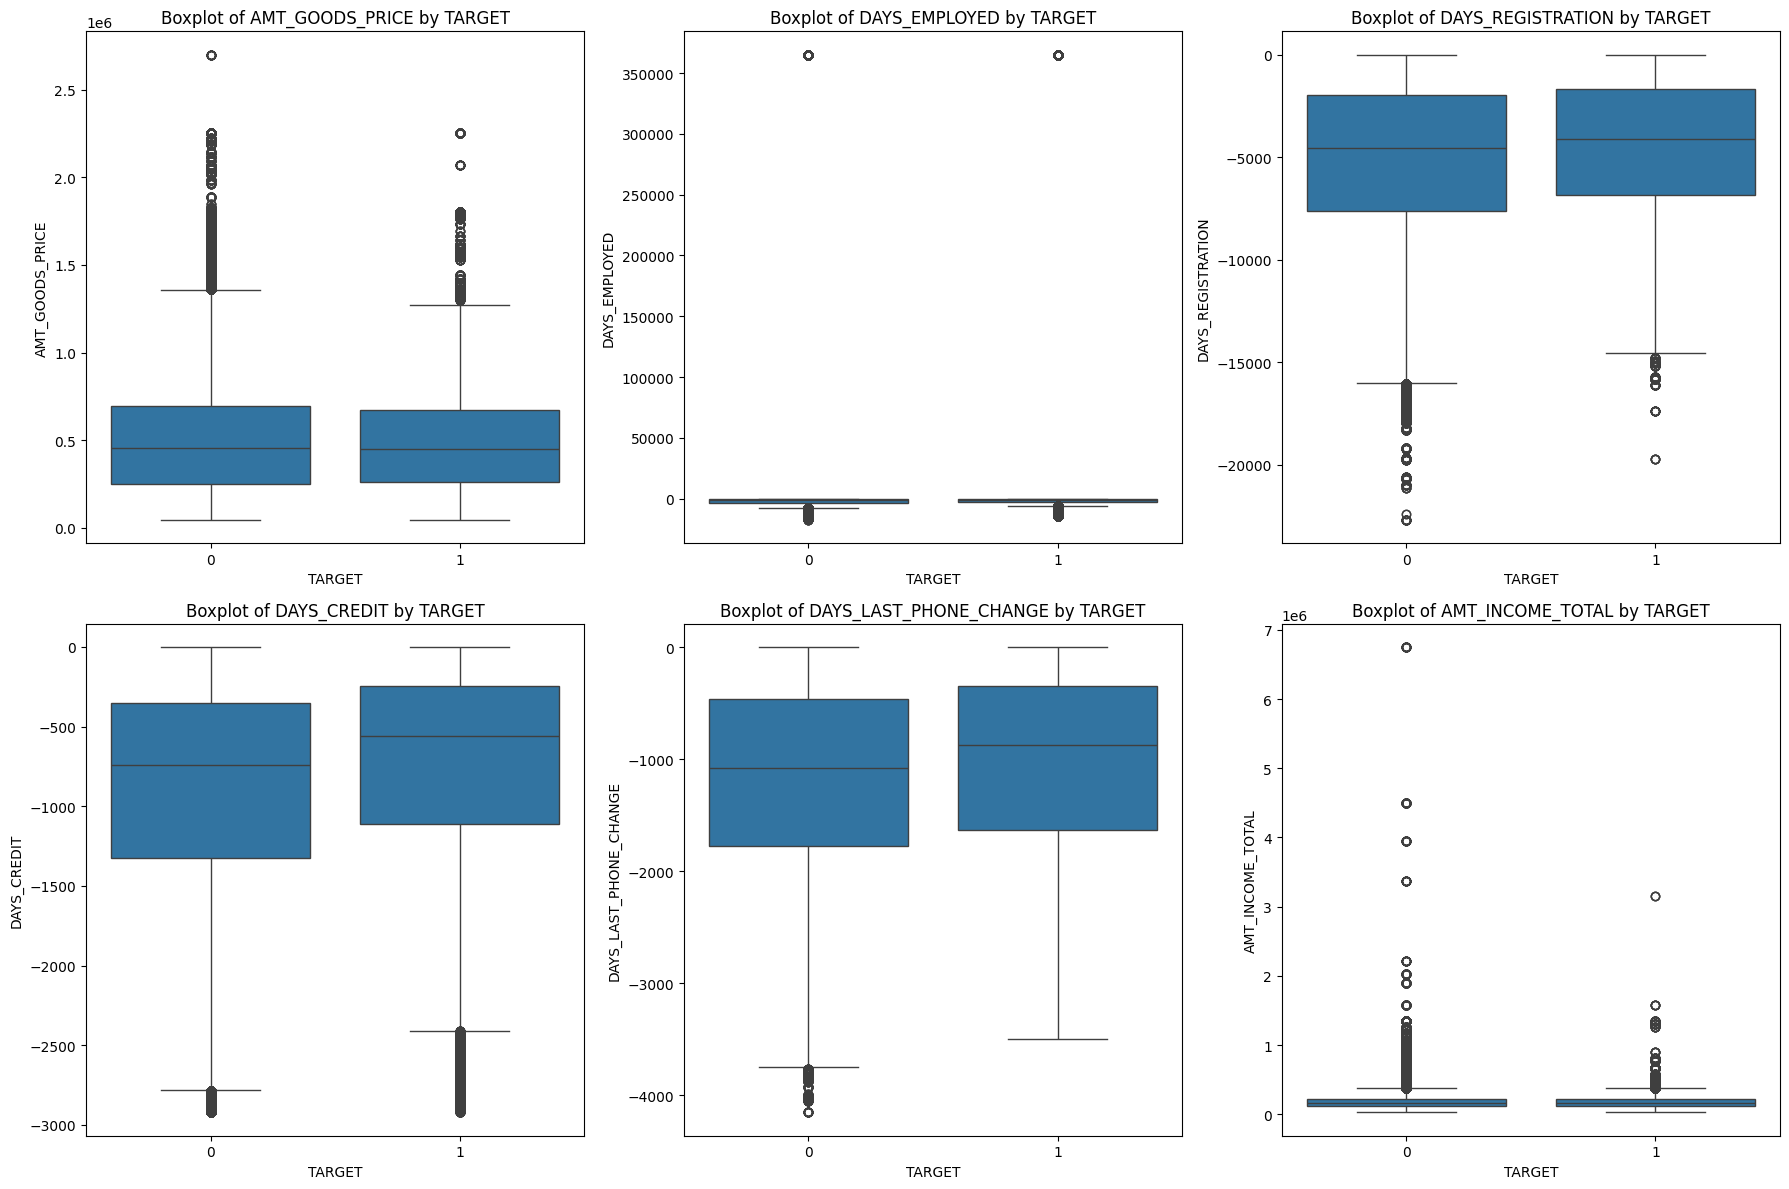

In [312]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Primeira fileira
sns.boxplot(x='TARGET', y='AMT_GOODS_PRICE', data=n, ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of AMT_GOODS_PRICE by TARGET')

sns.boxplot(x='TARGET', y='DAYS_EMPLOYED', data=n, ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of DAYS_EMPLOYED by TARGET')

sns.boxplot(x='TARGET', y='DAYS_REGISTRATION', data=n, ax=axes[0, 2])
axes[0, 2].set_title('Boxplot of DAYS_REGISTRATION by TARGET')

# Segunda fileira
sns.boxplot(x='TARGET', y='DAYS_CREDIT', data=n, ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of DAYS_CREDIT by TARGET')

sns.boxplot(x='TARGET', y='DAYS_LAST_PHONE_CHANGE', data=n, ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of DAYS_LAST_PHONE_CHANGE by TARGET')

sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=n, ax=axes[1, 2])
axes[1, 2].set_title('Boxplot of AMT_INCOME_TOTAL by TARGET')

plt.tight_layout()
plt.show()

A essas colunas com outliers será aplicada a função abaixo, para selecionar apenas as linhas que estejam dentro do limite definido pelos quartis. E para que não haja _data leakage_, os quartis serão calculados com base no dataframe de treino e aplicados ao dataframe de teste usando pipeline.

In [343]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Transformer customizado para remoção de outliers
class OutlierRemoval(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.limites = {}
    
    def fit(self, X, y=None):
        for column in self.columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR
            self.limites[column] = (limite_inferior, limite_superior)
        return self
    
    def transform(self, X):
        X_no_outliers = X.copy()
        for column, (limite_inferior, limite_superior) in self.limites.items():
            X_no_outliers = X_no_outliers[(X_no_outliers[column] >= limite_inferior) & (X_no_outliers[column] <= limite_superior)]
        return X_no_outliers

# Definir as colunas para remoção de outliers
columns_to_remove_outliers = [
    'AMT_GOODS_PRICE',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'DAYS_CREDIT',
    'DAYS_LAST_PHONE_CHANGE',
    'AMT_INCOME_TOTAL'
]

pipeline = Pipeline(steps=[
    ('outlier_removal', OutlierRemoval(columns=columns_to_remove_outliers)),
])

# Ajustar o Pipeline usando apenas os dados de treino
pipeline.fit(train_no_mult)

# Transformar os dados de treino e teste com o pipeline ajustado
train_no_out = pipeline.transform(train_no_mult)
test_no_out = pipeline.transform(test_no_mult)

E agora podemos ver uma melhora significativa nas representações abaixo.

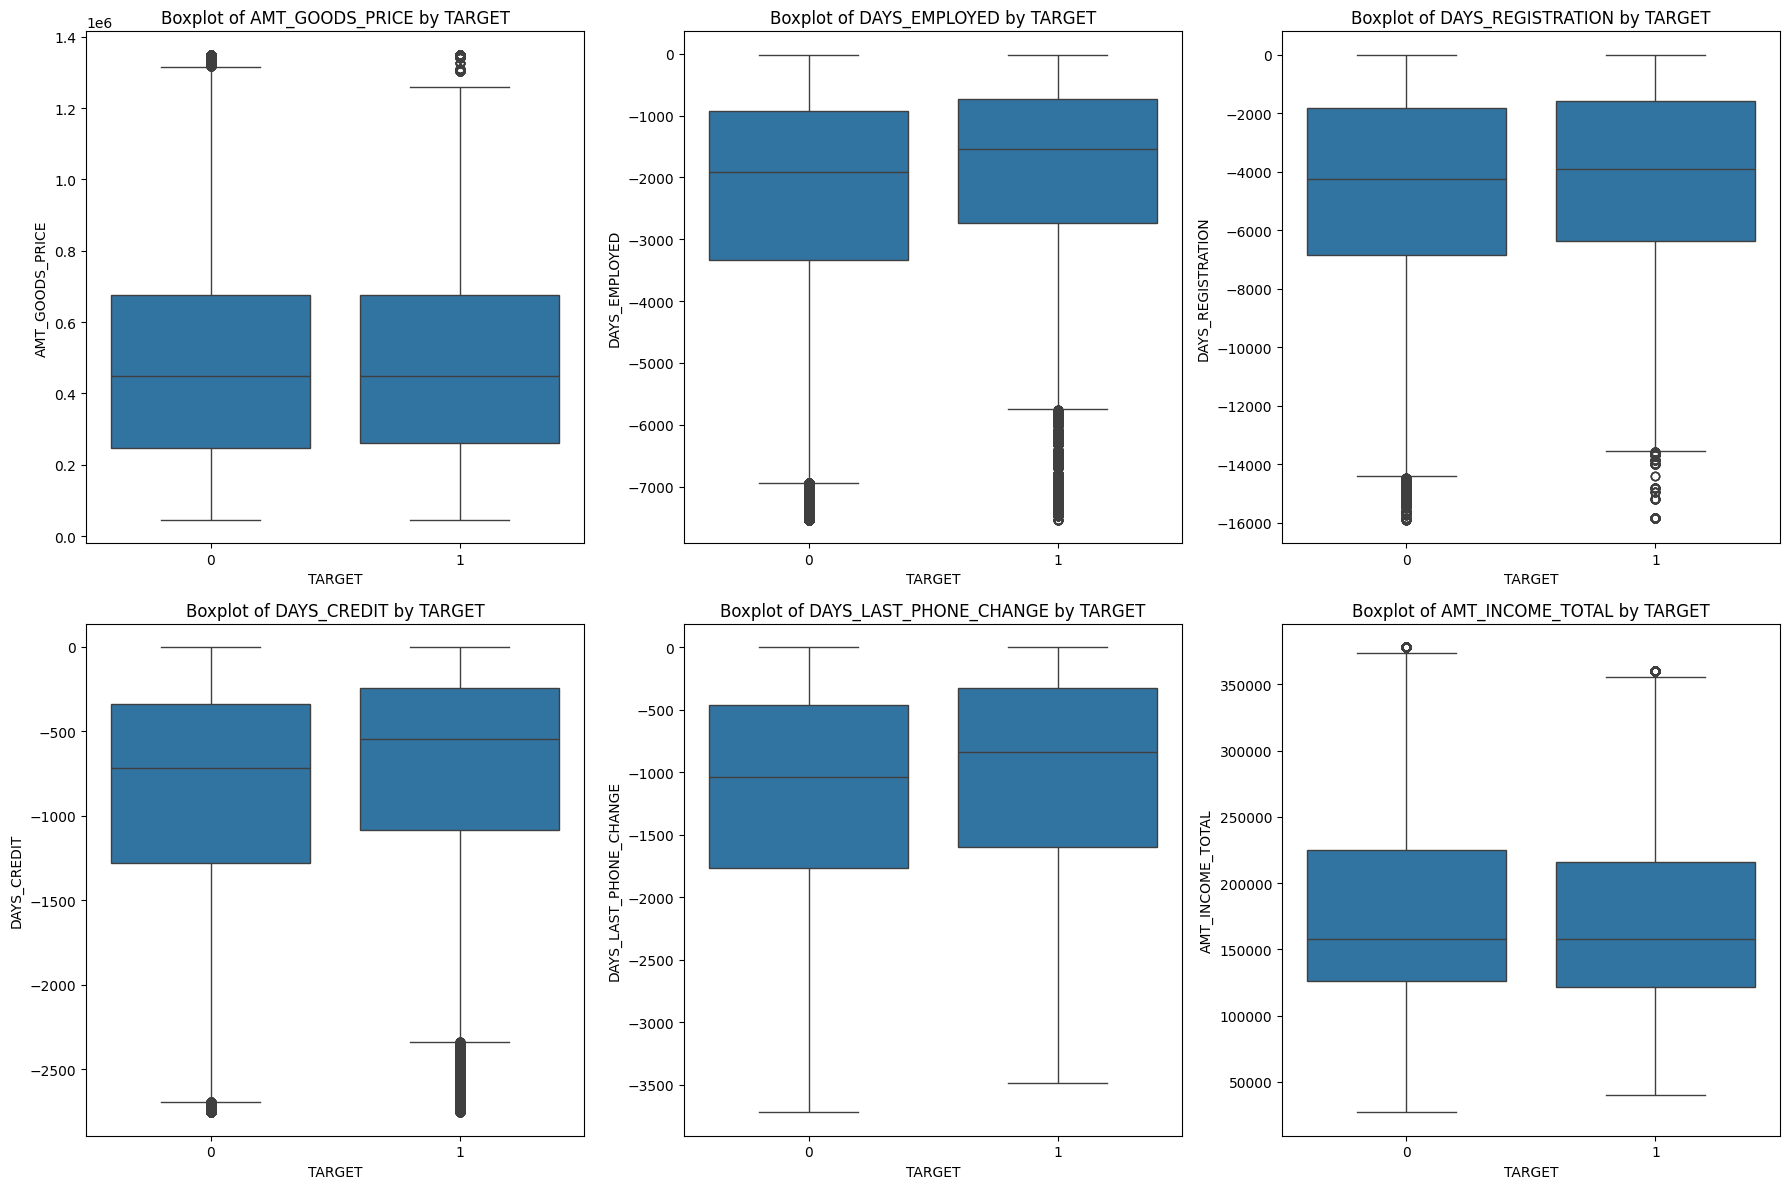

In [344]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 

# Primeira fileira
sns.boxplot(x='TARGET', y='AMT_GOODS_PRICE', data=train_no_out, ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of AMT_GOODS_PRICE by TARGET')

sns.boxplot(x='TARGET', y='DAYS_EMPLOYED', data=train_no_out, ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of DAYS_EMPLOYED by TARGET')

sns.boxplot(x='TARGET', y='DAYS_REGISTRATION', data=train_no_out, ax=axes[0, 2])
axes[0, 2].set_title('Boxplot of DAYS_REGISTRATION by TARGET')

# Segunda fileira
sns.boxplot(x='TARGET', y='DAYS_CREDIT', data=train_no_out, ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of DAYS_CREDIT by TARGET')

sns.boxplot(x='TARGET', y='DAYS_LAST_PHONE_CHANGE', data=train_no_out, ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of DAYS_LAST_PHONE_CHANGE by TARGET')

sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=train_no_out, ax=axes[1, 2])
axes[1, 2].set_title('Boxplot of AMT_INCOME_TOTAL by TARGET')

plt.tight_layout()
plt.show()

In [345]:
train_no_out.shape

(1081624, 35)

In [367]:
test_no_out.shape

(463156, 35)

In [370]:
463156/(463156+1081624) * 100

29.982003909941866

A porcentagem do dataframe de teste se manteve praticamente a mesma, portanto, não precisamos alterar a quantidade de dados nos dataframes.

# 3. Treinando o Modelo e Fazendo Previsões

In [347]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [348]:
def split_features_target(df, target_column='TARGET'):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

# Dividindo os dados em features e target
X_train, y_train = split_features_target(train_no_out)
X_test, y_test = split_features_target(test_no_out)

In [349]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.99960245 0.99954236 0.99957471 0.99963943 0.9995932 ]
Mean cross-validation score: 0.9995904306882725


O modelo está performando muito bem para praticamente todas as fatias.

In [351]:
# Selecionando as colunas numéricas e categóricas
numerical_features = X_train.select_dtypes(include=['number']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Pré-processamento para variáveis numéricas e categóricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Criação do ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Criação do Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [353]:
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Avaliação do modelo
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Test ROC AUC:", roc_auc_score(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

Train Accuracy: 1.0
Test Accuracy: 0.9998251129209165
Test ROC AUC: 0.9990187051754216
Confusion Matrix:
 [[421884      0]
 [    81  41191]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    421884
           1       1.00      1.00      1.00     41272

    accuracy                           1.00    463156
   macro avg       1.00      1.00      1.00    463156
weighted avg       1.00      1.00      1.00    463156



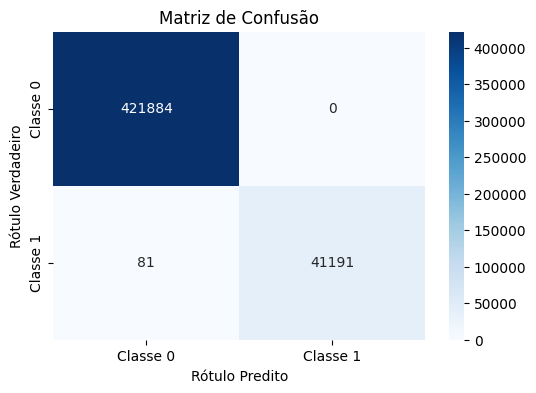

In [362]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred_test)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

A matriz de confusão mostra que o modelo não teve falsos positivos para inadimplente. Ou seja, ele não apontou ninguém erroneamente como inadimplente. Já no outro extremo, falsos negativos, ele errou em 81 dos casos. Mesmo assim, é um número bastante baixo.

AUC ROC: 1.00


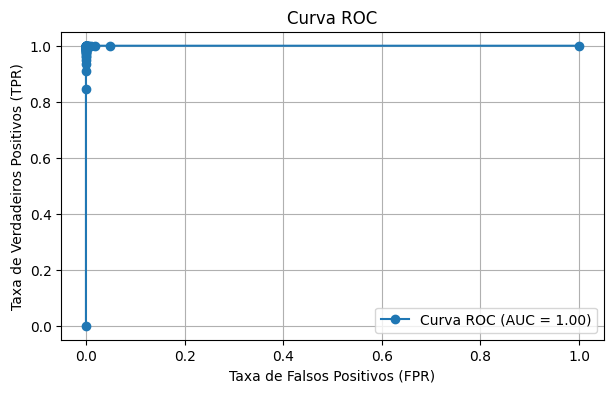

In [374]:
from sklearn.metrics import roc_curve, roc_auc_score

# Gerar previsões de probabilidade
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calcular FPR e TPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular o AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC ROC: {roc_auc:.2f}")

# Plotar a Curva ROC
plt.figure(figsize=(7, 4))
plt.plot(fpr, tpr, marker='o', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.show()

## EXTRA – Métricas do Modelo Influenciado por _Data Leakage_

Os dados abaixo são fruto de um erro! No entanto, há um propósito em colocá-los aqui. Essas métricas são do modelo influenciado por _data leakage_. 

Ao limpar os outliers do teste, eu inadvertidamente usei dados do próprio teste para medir os quartis. O curioso para mim é que, após corrigir o erro do _data leakage_... as métricas melhoraram! Faz sentido? Talvez porque após a correção o modelo ficou mais realista?

Train Accuracy: 1.0

Test Accuracy: 0.9997938547001128

Test ROC AUC: 0.9988440853673375

Confusion Matrix:

 [[419747      0]
 
 [    95  40998]]
 
Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    419747
           1       1.00      1.00      1.00     41093

    accuracy                           1.00    460840
    macro avg      1.00      1.00      1.00    460840
    weighted avg   1.00      1.00      1.00    460840


In [ ]:
Curva Roc e
Matriz de Confusão